In [25]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use("seaborn-v0_8-darkgrid")
import seaborn as sns
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200 , 'figure.figsize': (10, 5)})
sns.set_context('notebook')
sns.set_style("ticks")
sns.set_style('darkgrid')

from pycaret.regression import *

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML

In [26]:
# ADD TIME FEATURES
def add_time_features(df, time_column):
    
    df[time_column] = pd.to_datetime(df[time_column])  # Make sure the time column is in datetime format
    
    # Extract various time features
    #df['hour'] = df[time_column].dt.hour
    df['day_of_week'] = df[time_column].dt.dayofweek
    df['month'] = df[time_column].dt.month
    df['day_of_year'] = df[time_column].dt.dayofyear
    df['week_of_year'] = df[time_column].dt.isocalendar().week 
    df['year'] = df[time_column].dt.year

    df['sin_hour'] = np.sin(2*np.pi * df[time_column].dt.hour/24.)
    df['cos_hour'] = np.cos(2*np.pi * df[time_column].dt.hour/24.)
    
    return df

In [27]:
def add_interactions(df): 
    df['sun_elev_cloud_cover_interaction'] = df['sun_elevation:d'] * df['total_cloud_cover:p']

    df['radiation_interaction'] = df['clear_sky_rad:W'] * df['diffuse_rad:W'] * df['direct_rad:W']

    df['atmospheric_interaction'] = df['air_density_2m:kgm3'] * df['msl_pressure:hPa']

    df['temp_humidity_interaction'] = df['dew_point_2m:K'] * df['t_1000hPa:K']

    df['snow_radiation_interaction'] = df['fresh_snow_1h:cm'] * df['clear_sky_rad:W']  # Replace 'clear_sky_rad:W' with 'albedo' if available

    return df

In [28]:
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

def add_polynomial_features(df, feature_list, degree=2):
    """
    Adds polynomial features for specified features in a DataFrame.

    Parameters:
    - df: pandas.DataFrame - The original DataFrame.
    - feature_list: list - A list of column names to create polynomial features for.
    - degree: int - The degree of the polynomial features to create.

    Returns:
    - df: pandas.DataFrame - The DataFrame with added polynomial features.
    """

    # Initialize the PolynomialFeatures transformer
    poly_transformer = PolynomialFeatures(degree=degree, include_bias=False)

    for feature in feature_list:
        # Check if the feature exists in the dataframe to avoid KeyError
        if feature in df.columns:
            # Reshape the feature column to a 2D array for PolynomialFeatures
            feature_data = df[[feature]].values
            
            # Create polynomial features for the selected feature
            feature_poly = poly_transformer.fit_transform(feature_data)
            
            # Generate new feature names
            feature_names = [f"{feature}^{i}" for i in range(1, degree + 1)]
            
            # Convert the output array to a DataFrame with new feature names
            feature_poly_df = pd.DataFrame(feature_poly, columns=feature_names)
            
            # Concatenate the new polynomial features to the original DataFrame
            df = pd.concat([df, feature_poly_df.iloc[:, 1:]], axis=1)  # Skip the original feature column
            
    return df

def add_rolling_average(df, window_size, fill_method='ffill'):
    """
    Adds rolling average columns to the dataframe based on the specified window size.
    Args:
    - df: The input dataframe.
    - window_size: The number of periods to consider for calculating the rolling average.
    
    Returns:
    - df with new columns for the rolling averages of selected features.
    """
    rolling_features = ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm',
       'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_depth:cm',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms']
    for feature in rolling_features:
        rolling_name = f'{feature}_rolling_avg_{window_size}'
        df[rolling_name] = df[feature].rolling(window=window_size, min_periods=1, center=True).mean()

        # Handle NaN values at the edges
        if fill_method == 'ffill':
            df[rolling_name].fillna(method='ffill', inplace=True)
        elif fill_method == 'bfill':
            df[rolling_name].fillna(method='bfill', inplace=True)
    return df

In [29]:

def plot_targets(targets, start_date, end_date):
    # Slice the dataframe based on the provided start and end dates
    targets_subset = targets[(targets['time'] >= start_date) & (targets['time'] <= end_date)]

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(targets_subset['time'], targets_subset['pv_measurement'], label='PV Measurement')
    plt.xlabel('Time')
    plt.ylabel('PV Measurement')
    plt.title('PV Measurement Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [30]:
def make_categorical(df, feature_list):
    for feature in feature_list:
        df[feature] = df[feature].astype('category')
    return df

In [31]:
def add_time_delta(observed, estimated, test):
    estimated['time_delta'] = (estimated['date_forecast'] - estimated['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
    observed['time_delta'] = 0
    test['time_delta'] = (test['date_forecast'] - test['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
    return observed, estimated, test

def add_is_estimated(observed, estimated, test):
    estimated['is_estimated'] = 1
    observed['is_estimated'] = 0
    test['is_estimated'] = 1
    return observed, estimated, test

def process_data(observed, estimated, test):
    observed, estimated, test = add_time_delta(observed, estimated, test)
    observed, estimated, test = add_is_estimated(observed, estimated, test)
    train = pd.concat([observed, estimated], axis=0).sort_values(by='date_forecast')
    return train, test

def set_date_time(targets, observed, estimated, test):
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])
    return targets, observed, estimated, test

def resample_data(observed, estimated, test):
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    return observed_resampled, estimated_resampled, test_resampled

def extract_is_day_feature(test):
    is_day_feature = test[['date_forecast', 'is_day:idx']]
    is_day_feature['is_day:idx'] = is_day_feature['is_day:idx'].replace({0.25: 1, 0.5: 1, 0.75: 1, 1: 1, 0: 0})
    return is_day_feature

def extract_time_limit(targets):
    first_date = targets['time'].min()
    last_date = targets['time'].max()
    return first_date, last_date

def drop_features(train, test):
    train = train.drop(columns=['time', 'date_forecast', 'pv_measurement'])
    test = test.drop(columns=['date_forecast'])
    return train, test

def add_several_rolling_average(train, test, lst_of_window_sizes):
    for size in lst_of_window_sizes: 
        train = add_rolling_average(train, window_size=size)
        test = add_rolling_average(test, window_size=size)
    return train, test

In [32]:
def calculate_incidence_angles(df, latitude = 60):
    # Define a function to calculate the angle of incidence for a given row
    def angle_of_incidence(row, tilt_angle_rad, panel_azimuth_rad):
        sun_elevation_rad = np.radians(row['sun_elevation:d'])
        sun_azimuth_rad = np.radians(row['sun_azimuth:d'])
        cos_theta = (
            np.sin(sun_elevation_rad) * np.sin(tilt_angle_rad) +
            np.cos(sun_elevation_rad) * np.cos(tilt_angle_rad) * np.cos(sun_azimuth_rad - panel_azimuth_rad)
        )
        cos_theta = np.clip(cos_theta, -1, 1)  # Ensure cos_theta is within valid range
        return np.degrees(np.arccos(cos_theta))
    
    # Calculate the tilt angle and panel azimuth assuming Norway is in the northern hemisphere
    tilt_angle_rad = np.radians(latitude)
    panel_azimuth_rad = 0  # True south

    # Apply the angle_of_incidence function to each row
    df['angle_of_incidence'] = df.apply(angle_of_incidence, axis=1, tilt_angle_rad=tilt_angle_rad, panel_azimuth_rad=panel_azimuth_rad)
    
    return df

In [33]:
def add_wind_features(train, test):
    for df in [train, test]:
        # Horizontal wind speed magnitude at 10 meters
        df['wind_speed_10m_vector_magnitude:ms'] = np.sqrt(df['wind_speed_u_10m:ms']**2 + df['wind_speed_v_10m:ms']**2)

        # Wind direction at 10 meters
        df['wind_direction_10m:degrees'] = np.degrees(np.arctan2(df['wind_speed_v_10m:ms'], df['wind_speed_u_10m:ms']))

        # Temperature-adjusted wind speed at 10 meters
        df['temp_adjusted_wind_speed_10m:ms'] = df['wind_speed_10m:ms'] * (df['t_1000hPa:K'] / 273.15)

        # Vertical wind shear between surface and 1000 hPa
        # Note: this requires careful interpretation as mentioned earlier
        df['wind_shear_1000hPa_10m:ms'] = df['wind_speed_w_1000hPa:ms'] - df['wind_speed_10m:ms']

        # Wind energy density at 10 meters
        df['wind_energy_density_10m:Wm2'] = 0.5 * 1.225 * (df['wind_speed_10m:ms']**3)  # Using 1.225 kg/m3 as air density at sea level

    return train, test

In [34]:
def remove_constant_blocks(df):
    '''
    Remove constant blocks from the dataframe, i.e. where the value in pv_measurement is constant
    Ex: 0,0,1 -> 0,1
    '''
    df['diff'] = df['pv_measurement'].diff().fillna(0)
    df['constant'] = (df['diff'] == 0).astype(int)
    df['block'] = (df['constant'].diff() != 0).astype(int).cumsum()
    df['block_size'] = df.groupby('block')['constant'].transform('sum') # This gets the size per block

    # Keep the first occurrence by ensuring the block size is greater than 1 and that it's a constant value.
    df = df[~((df['block_size'] >= 1) & (df['pv_measurement'] != 0))]

    # Drop the helper columns
    df.drop(['diff', 'constant', 'block', 'block_size'], axis=1, inplace=True)
    
    return df

# def remove_nonzero_constant_blocks(df, column='pv_measurement'):
#     '''
#     Remove constant blocks from the dataframe where the value in the specified column is constant and non-zero.
#     Ex: 0,0,1,1,1 -> 0,0
#         2,2,0,0,1 -> 0,0,1
#     '''
#     # Calculate the difference between consecutive rows and identify constant blocks
#     df['diff'] = df[column].diff().fillna(0)
#     df['constant'] = (df['diff'] == 0).astype(int)
#     df['block'] = (df['constant'].diff() != 0).astype(int).cumsum()
    
#     # Determine the value of each block and its size
#     df['block_value'] = df.groupby('block')[column].transform('first') # The value of the block
#     df['block_size'] = df.groupby('block')['constant'].transform('sum') # This gets the size per block
    
#     # We only want to keep the block if its size is 1 (non-constant) or if the constant value is 0
#     # This is done by checking if the block size is 1 or if the block value is 0.
#     df = df[(df['block_size'] == 1) | (df['block_value'] == 0)]
    
#     # Drop the helper columns
#     df.drop(['diff', 'constant', 'block', 'block_value', 'block_size'], axis=1, inplace=True)
    
#     return df

In [35]:
def preprocessing(targets, observed, estimated, test):
    targets, observed, estimated, test = set_date_time(targets, observed, estimated, test)
    
    observed, estimated, test = resample_data(observed, estimated, test)

    is_day_feature = extract_is_day_feature(test)

    first_date, last_date = extract_time_limit(targets)
    start_date, end_date = '2017-07-01', '2024-08-30'  
   
    
    train, test = process_data(observed, estimated, test)

    train, test = add_several_rolling_average(train, test, lst_of_window_sizes = [3, 5, 7])

    merged_data = pd.merge(targets, train, how='inner', left_on='time', right_on='date_forecast')

    # Remove constant blocks from the data
    train = remove_constant_blocks(merged_data)

    ###### This one should be double checked ########
    # Remove rows where pv_measurement is 0
    train = train[merged_data['pv_measurement'] != 0]

    # Add the time-based features
    train = add_time_features(train, 'time')  
    test = add_time_features(test, 'date_forecast') 

    targets = train[['time', 'pv_measurement']]
    
    # plot_targets(targets, start_date, end_date)

    train, test = drop_features(train, test)

    # train = calculate_incidence_angles(train)
    # test = calculate_incidence_angles(test)

    # train, test = add_wind_features(train, test)

    return train, test, is_day_feature, targets

In [36]:
from pycaret.regression import *
def process_location_catboost(exp_reg):
    
    catboost = exp_reg.create_model('catboost', random_state = 123)
    #catboost = exp_reg.tune_model(catboost)
    #catboost = exp_reg.ensemble_model(catboost, method='Bagging')

    return catboost

def process_location_lightgbm(exp_reg):

    lightgbm = exp_reg.create_model('lightgbm', random_state = 123)
    #lightgbm = exp_reg.tune_model(lightgbm)
    #lightgbm = exp_reg.ensemble_model(lightgbm, method='Bagging')

    return lightgbm

def process_location_xtra_tree(exp_reg):
    
    xtra_tree = exp_reg.create_model('et', random_state = 123)
    #xtra_tree = exp_reg.tune_model(xtra_tree)
    #xtra_tree = exp_reg.ensemble_model(xtra_tree, method='Bagging')

    return xtra_tree


# Run

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(18036, 163)"
4,Transformed data shape,"(18036, 175)"
5,Transformed train set shape,"(12625, 175)"
6,Transformed test set shape,"(5411, 175)"
7,Ordinal features,1
8,Numeric features,159
9,Categorical features,3


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.5244,37.9373,6.1593,0.9031,0.2997,0.3298
1,4.3413,36.9888,6.0818,0.9032,0.2805,0.2828
2,4.3846,38.3860,6.1956,0.8996,0.2901,0.2890
3,4.3951,38.2157,6.1819,0.9000,0.2913,0.2794
4,4.7321,44.3938,6.6629,0.8850,0.2962,0.2929
5,4.6688,42.0393,6.4838,0.8946,0.2970,0.2940
6,4.4576,39.7464,6.3045,0.8998,0.2985,0.3103
7,4.5256,41.2853,6.4254,0.8994,0.2879,0.2740
8,4.4907,39.8542,6.3130,0.8981,0.2853,0.2763


Catboost Done
#############################################


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.7765,42.1181,6.4898,0.8924,0.3055,0.3442
1,4.4409,39.3871,6.2759,0.8970,0.2864,0.2919
2,4.6158,42.3433,6.5072,0.8892,0.2962,0.3083
3,4.4712,40.2525,6.3445,0.8947,0.2919,0.2867
4,4.8601,46.4862,6.8181,0.8795,0.2968,0.3078
5,4.7542,44.3551,6.6600,0.8888,0.2909,0.2931
6,4.6212,42.6796,6.5330,0.8924,0.3035,0.3237
7,4.7335,45.2940,6.7301,0.8896,0.2890,0.2830
8,4.7084,43.9021,6.6259,0.8878,0.2922,0.2935


LGBM Done
#############################################
Cat: 126
LGBM: 38
A Removes: 37 features
A Keep: 126 features
['dew_or_rimeidx', 'is_in_shadowidx']


,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(18036, 163)"
4,Transformed data shape,"(18036, 152)"
5,Transformed train set shape,"(12625, 152)"
6,Transformed test set shape,"(5411, 152)"
7,Ignore features,37
8,Numeric features,137
9,Categorical features,2


['is_dayidx', 'snow_densitykgm3', 'dew_or_rimeidx_0.75', 'fresh_snow_6hcm', 'is_estimated', 'fresh_snow_1hcm_rolling_avg_3', 'elevationm', 'dew_or_rimeidx_-0.25', 'dew_or_rimeidx_0.5', 'dew_or_rimeidx_-0.75', 'dew_or_rimeidx_1.0', 'is_in_shadowidx_1.0', 'fresh_snow_1hcm', 'wind_speed_w_1000hPams', 'is_in_shadowidx_0.5', 'prob_rimep', 'fresh_snow_6hcm_rolling_avg_5', 'snow_melt_10minmm', 'dew_or_rimeidx_-1.0', 'dew_or_rimeidx_-0.5', 'snow_melt_10minmm_rolling_avg_3', 'fresh_snow_24hcm_rolling_avg_5', 'dew_or_rimeidx_0.0', 'snow_driftidx', 'is_in_shadowidx_0.75', 'fresh_snow_24hcm_rolling_avg_3', 'is_in_shadowidx_0.25', 'fresh_snow_3hcm_rolling_avg_3', 'prob_rimep_rolling_avg_7', 'fresh_snow_3hcm', 'prob_rimep_rolling_avg_5', 'dew_or_rimeidx_0.25', 'prob_rimep_rolling_avg_3', 'snow_melt_10minmm_rolling_avg_7', 'is_in_shadowidx_0.0', 'fresh_snow_6hcm_rolling_avg_3', 'fresh_snow_1hcm_rolling_avg_5']


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.5504,38.5434,6.2083,0.9015,0.3025,0.3271
1,4.3387,37.2471,6.1030,0.9026,0.2829,0.2812
2,4.4015,38.9902,6.2442,0.8980,0.2910,0.2883
3,4.3505,37.7246,6.1420,0.9013,0.2914,0.2785
4,4.7146,44.1997,6.6483,0.8855,0.2970,0.2934
5,4.6300,41.9092,6.4737,0.8949,0.2837,0.2772
6,4.4691,39.2770,6.2671,0.9009,0.3027,0.3194
7,4.5326,41.2321,6.4212,0.8995,0.2842,0.2754
8,4.4932,40.2453,6.3439,0.8971,0.2818,0.2704


Catboost redused Done
#############################################


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.7312,41.5438,6.4454,0.8938,0.3023,0.3397
1,4.4517,39.6321,6.2954,0.8963,0.2848,0.2897
2,4.5410,41.2394,6.4218,0.8921,0.2923,0.3032
3,4.5444,41.4188,6.4357,0.8917,0.2913,0.2868
4,4.8649,47.1353,6.8655,0.8779,0.2968,0.3061
5,4.7096,44.1283,6.6429,0.8893,0.2894,0.2892
6,4.6185,41.9374,6.4759,0.8942,0.3030,0.3277
7,4.7601,45.6611,6.7573,0.8887,0.2900,0.2845
8,4.6757,43.6566,6.6073,0.8884,0.2906,0.2923


LGBM redused Done
#############################################


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.5691,38.9910,6.2443,0.9004,0.2935,0.3235
1,4.3156,37.4665,6.1210,0.9020,0.2742,0.2753
2,4.3873,39.1335,6.2557,0.8976,0.2831,0.2851
3,4.3690,38.4913,6.2041,0.8993,0.2842,0.2761
4,4.7299,44.6557,6.6825,0.8843,0.2881,0.2919
5,4.6099,41.9904,6.4800,0.8947,0.2777,0.2735
6,4.4655,39.6038,6.2932,0.9001,0.2950,0.3144
7,4.5623,42.3735,6.5095,0.8967,0.2798,0.2700
8,4.5103,40.8781,6.3936,0.8955,0.2781,0.2731


Blended
#############################################
Finalized
#############################################


float64
date_forecast    datetime64[ns]
is_day:idx              float32
dtype: object


,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(12274, 163)"
4,Transformed data shape,"(12274, 174)"
5,Transformed train set shape,"(8591, 174)"
6,Transformed test set shape,"(3683, 174)"
7,Ordinal features,1
8,Numeric features,159
9,Categorical features,3


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.7364,5.7282,2.3934,0.9254,0.2516,0.2771
1,1.7061,5.9681,2.4430,0.9175,0.2381,0.2415
2,1.6971,5.5736,2.3608,0.9225,0.2471,0.2640
3,1.6389,5.2911,2.3002,0.9274,0.2524,0.2543
4,1.6657,5.3922,2.3221,0.9262,0.2488,0.2578
5,1.7203,5.7323,2.3942,0.9202,0.2596,0.2833
6,1.7383,6.0952,2.4688,0.9174,0.2625,0.2681
7,1.7122,5.7933,2.4069,0.9228,0.2724,0.2964
8,1.8163,7.1215,2.6686,0.9069,0.2584,0.3936


Catboost Done
#############################################


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.8009,6.2394,2.4979,0.9187,0.2668,0.3022
1,1.7809,6.3176,2.5135,0.9127,0.2522,0.2656
2,1.7387,5.8087,2.4101,0.9192,0.2476,0.2655
3,1.7431,5.6712,2.3814,0.9222,0.2611,0.2733
4,1.7606,5.8328,2.4151,0.9202,0.2634,0.2802
5,1.8089,6.1959,2.4892,0.9138,0.2704,0.3022
6,1.7982,6.4549,2.5406,0.9125,0.2767,0.2918
7,1.7904,6.3009,2.5102,0.9160,0.2866,0.3240
8,1.8976,7.5310,2.7443,0.9016,0.2683,0.4041


LGBM Done
#############################################
Cat: 118
LGBM: 32
B Removes: 32 features
B Keep: 131 features
['dew_or_rimeidx', 'is_in_shadowidx']


,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(12274, 163)"
4,Transformed data shape,"(12274, 154)"
5,Transformed train set shape,"(8591, 154)"
6,Transformed test set shape,"(3683, 154)"
7,Ignore features,32
8,Numeric features,140
9,Categorical features,2


['is_dayidx', 'snow_densitykgm3', 'dew_or_rimeidx_0.75', 'fresh_snow_6hcm', 'is_estimated', 'fresh_snow_1hcm_rolling_avg_3', 'elevationm', 'fresh_snow_3hcm_rolling_avg_5', 'dew_or_rimeidx_-0.25', 'dew_or_rimeidx_0.5', 'dew_or_rimeidx_1.0', 'is_in_shadowidx_1.0', 'fresh_snow_1hcm', 'wind_speed_w_1000hPams', 'is_in_shadowidx_0.5', 'prob_rimep', 'fresh_snow_6hcm_rolling_avg_5', 'snow_melt_10minmm', 'dew_or_rimeidx_-1.0', 'snow_melt_10minmm_rolling_avg_3', 'dew_or_rimeidx_0.0', 'snow_driftidx', 'is_in_shadowidx_0.75', 'is_in_shadowidx_0.25', 'fresh_snow_1hcm_rolling_avg_7', 'fresh_snow_3hcm_rolling_avg_3', 'fresh_snow_3hcm', 'dew_or_rimeidx_0.25', 'prob_rimep_rolling_avg_3', 'dew_or_rimeidx_-0.5', 'fresh_snow_6hcm_rolling_avg_3', 'fresh_snow_1hcm_rolling_avg_5']


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.7270,5.8293,2.4144,0.9240,0.2533,0.2766
1,1.7106,6.0496,2.4596,0.9164,0.2378,0.2419
2,1.6954,5.6810,2.3835,0.9210,0.2419,0.2647
3,1.6596,5.3278,2.3082,0.9269,0.2501,0.2530
4,1.6486,5.2965,2.3014,0.9275,0.2473,0.2569
5,1.7018,5.6788,2.3830,0.9210,0.2576,0.2742
6,1.7419,6.2194,2.4939,0.9157,0.2662,0.2658
7,1.7220,5.8934,2.4276,0.9214,0.2729,0.3000
8,1.8171,7.2335,2.6895,0.9055,0.2598,0.3745


Catboost redused Done
#############################################


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.8167,6.3465,2.5192,0.9173,0.2635,0.3052
1,1.7816,6.2189,2.4938,0.9140,0.2499,0.2620
2,1.7360,5.7677,2.4016,0.9198,0.2474,0.2657
3,1.7168,5.5822,2.3627,0.9234,0.2565,0.2676
4,1.7517,5.8463,2.4179,0.9200,0.2625,0.2804
5,1.8409,6.2853,2.5071,0.9125,0.2756,0.3141
6,1.8290,6.7284,2.5939,0.9088,0.2784,0.2965
7,1.7967,6.2411,2.4982,0.9168,0.2841,0.3186
8,1.8925,7.5361,2.7452,0.9015,0.2674,0.4667


LGBM redused Done
#############################################


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.7477,5.9226,2.4336,0.9228,0.2544,0.2861
1,1.7191,5.9621,2.4417,0.9176,0.2393,0.2473
2,1.6855,5.5607,2.3581,0.9226,0.2383,0.2587
3,1.6590,5.2774,2.2973,0.9276,0.2487,0.2564
4,1.6669,5.3977,2.3233,0.9261,0.2512,0.2630
5,1.7508,5.8175,2.4120,0.9191,0.2616,0.2898
6,1.7553,6.2927,2.5085,0.9147,0.2679,0.2766
7,1.7257,5.9061,2.4303,0.9213,0.2742,0.3032
8,1.8283,7.2023,2.6837,0.9059,0.2591,0.4168


Blended
#############################################
Finalized
#############################################


float64
date_forecast    datetime64[ns]
is_day:idx              float32
dtype: object


,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(9676, 163)"
4,Transformed data shape,"(9676, 175)"
5,Transformed train set shape,"(6773, 175)"
6,Transformed test set shape,"(2903, 175)"
7,Ordinal features,1
8,Numeric features,159
9,Categorical features,3


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5758,5.1898,2.2781,0.9021,0.2015,0.1772
1,1.4715,4.4499,2.1095,0.9216,0.1969,0.1781
2,1.4607,4.3054,2.0750,0.9200,0.1802,0.1576
3,1.6339,5.5850,2.3633,0.8909,0.2095,0.1846
4,1.5017,4.5001,2.1213,0.9204,0.1866,0.1673
5,1.4838,4.4141,2.1010,0.9163,0.1790,0.1616
6,1.5840,5.2778,2.2973,0.8938,0.1910,0.1694
7,1.5963,5.2193,2.2846,0.8979,0.2265,0.2118
8,1.5155,4.5222,2.1265,0.9153,0.1961,0.1764


Catboost Done
#############################################


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.6136,5.5643,2.3589,0.8950,0.2141,0.1897
1,1.5787,5.0327,2.2434,0.9113,0.2056,0.1877
2,1.5416,4.7506,2.1796,0.9117,0.1894,0.1660
3,1.7179,6.2791,2.5058,0.8773,0.2271,0.2032
4,1.5483,4.7635,2.1825,0.9157,0.1997,0.1791
5,1.5449,4.7536,2.1803,0.9098,0.1866,0.1683
6,1.6098,5.3787,2.3192,0.8918,0.1954,0.1755
7,1.6791,5.9035,2.4297,0.8845,0.2410,0.2275
8,1.5947,4.8995,2.2135,0.9082,0.2045,0.1887


LGBM Done
#############################################
Cat: 122
LGBM: 36
C Removes: 35 features
C Keep: 128 features
['dew_or_rimeidx', 'is_in_shadowidx', 'is_estimated']


,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(9676, 163)"
4,Transformed data shape,"(9676, 154)"
5,Transformed train set shape,"(6773, 154)"
6,Transformed test set shape,"(2903, 154)"
7,Ignore features,35
8,Ordinal features,1
9,Numeric features,138


['is_dayidx', 'snow_densitykgm3', 'dew_or_rimeidx_0.75', 'fresh_snow_1hcm_rolling_avg_3', 'elevationm', 'dew_or_rimeidx_-0.25', 'dew_or_rimeidx_0.5', 'dew_or_rimeidx_-0.75', 'dew_or_rimeidx_1.0', 'is_in_shadowidx_1.0', 'snow_depthcm', 'fresh_snow_1hcm', 'is_in_shadowidx_0.5', 'prob_rimep', 'snow_depthcm_rolling_avg_3', 'snow_melt_10minmm', 'dew_or_rimeidx_-1.0', 'dew_or_rimeidx_-0.5', 'fresh_snow_24hcm_rolling_avg_5', 'snow_melt_10minmm_rolling_avg_3', 'dew_or_rimeidx_0.0', 'snow_driftidx', 'is_in_shadowidx_0.75', 'is_in_shadowidx_0.25', 'fresh_snow_1hcm_rolling_avg_7', 'fresh_snow_3hcm_rolling_avg_3', 'fresh_snow_3hcm', 'prob_rimep_rolling_avg_5', 'dew_or_rimeidx_0.25', 'snow_melt_10minmm_rolling_avg_5', 'prob_rimep_rolling_avg_3', 'snow_melt_10minmm_rolling_avg_7', 'is_in_shadowidx_0.0', 'snow_depthcm_rolling_avg_5', 'fresh_snow_1hcm_rolling_avg_5']


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5698,5.1961,2.2795,0.9020,0.2017,0.1759
1,1.4684,4.3332,2.0816,0.9236,0.1953,0.1776
2,1.4753,4.3784,2.0925,0.9186,0.1809,0.1593
3,1.6216,5.6144,2.3695,0.8903,0.2106,0.1860
4,1.5117,4.5748,2.1389,0.9190,0.1902,0.1708
5,1.5096,4.5694,2.1376,0.9133,0.1836,0.1653
6,1.5632,5.2636,2.2942,0.8941,0.1892,0.1659
7,1.5992,5.2488,2.2910,0.8974,0.2260,0.2111
8,1.5079,4.4753,2.1155,0.9162,0.1956,0.1768


Catboost redused Done
#############################################


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.6136,5.5643,2.3589,0.8950,0.2141,0.1897
1,1.5882,5.1158,2.2618,0.9098,0.2083,0.1895
2,1.5326,4.7307,2.1750,0.9121,0.1902,0.1662
3,1.7414,6.4302,2.5358,0.8744,0.2321,0.2095
4,1.5446,4.7534,2.1802,0.9159,0.1982,0.1780
5,1.5449,4.7536,2.1803,0.9098,0.1866,0.1683
6,1.6044,5.3559,2.3143,0.8923,0.1935,0.1729
7,1.6673,5.8375,2.4161,0.8858,0.2381,0.2231
8,1.5876,4.8759,2.2082,0.9087,0.2054,0.1896


LGBM redused Done
#############################################


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5722,5.2456,2.2903,0.9010,0.2052,0.1805
1,1.5032,4.5733,2.1385,0.9194,0.1985,0.1802
2,1.4739,4.4039,2.0986,0.9182,0.1818,0.1591
3,1.6557,5.8330,2.4152,0.8860,0.2172,0.1933
4,1.4985,4.5116,2.1241,0.9201,0.1915,0.1716
5,1.5008,4.5269,2.1276,0.9141,0.1818,0.1640
6,1.5587,5.1735,2.2745,0.8959,0.1886,0.1669
7,1.6076,5.3644,2.3161,0.8951,0.2292,0.2142
8,1.5256,4.5572,2.1348,0.9146,0.1979,0.1805


Blended
#############################################
Finalized
#############################################


float64
date_forecast    datetime64[ns]
is_day:idx              float32
dtype: object


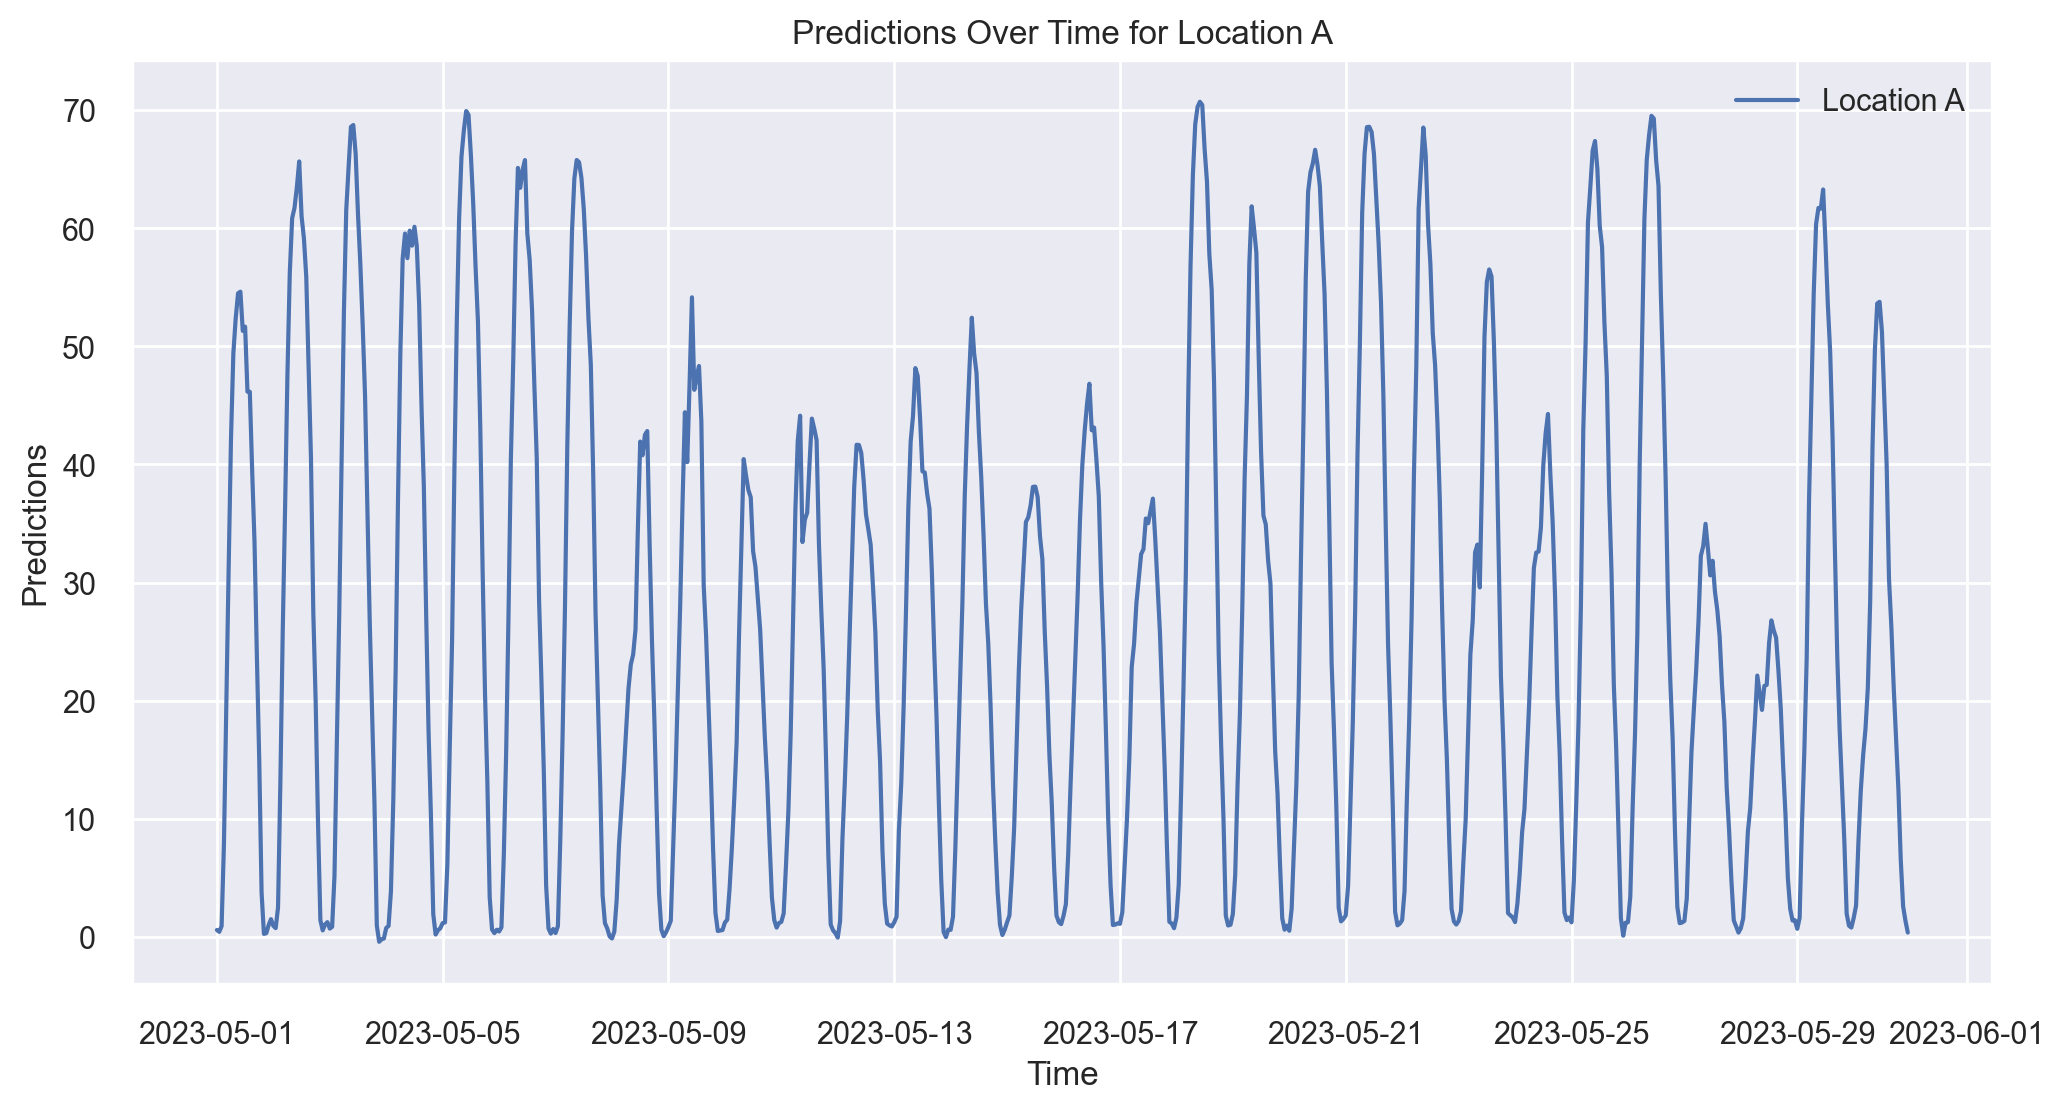

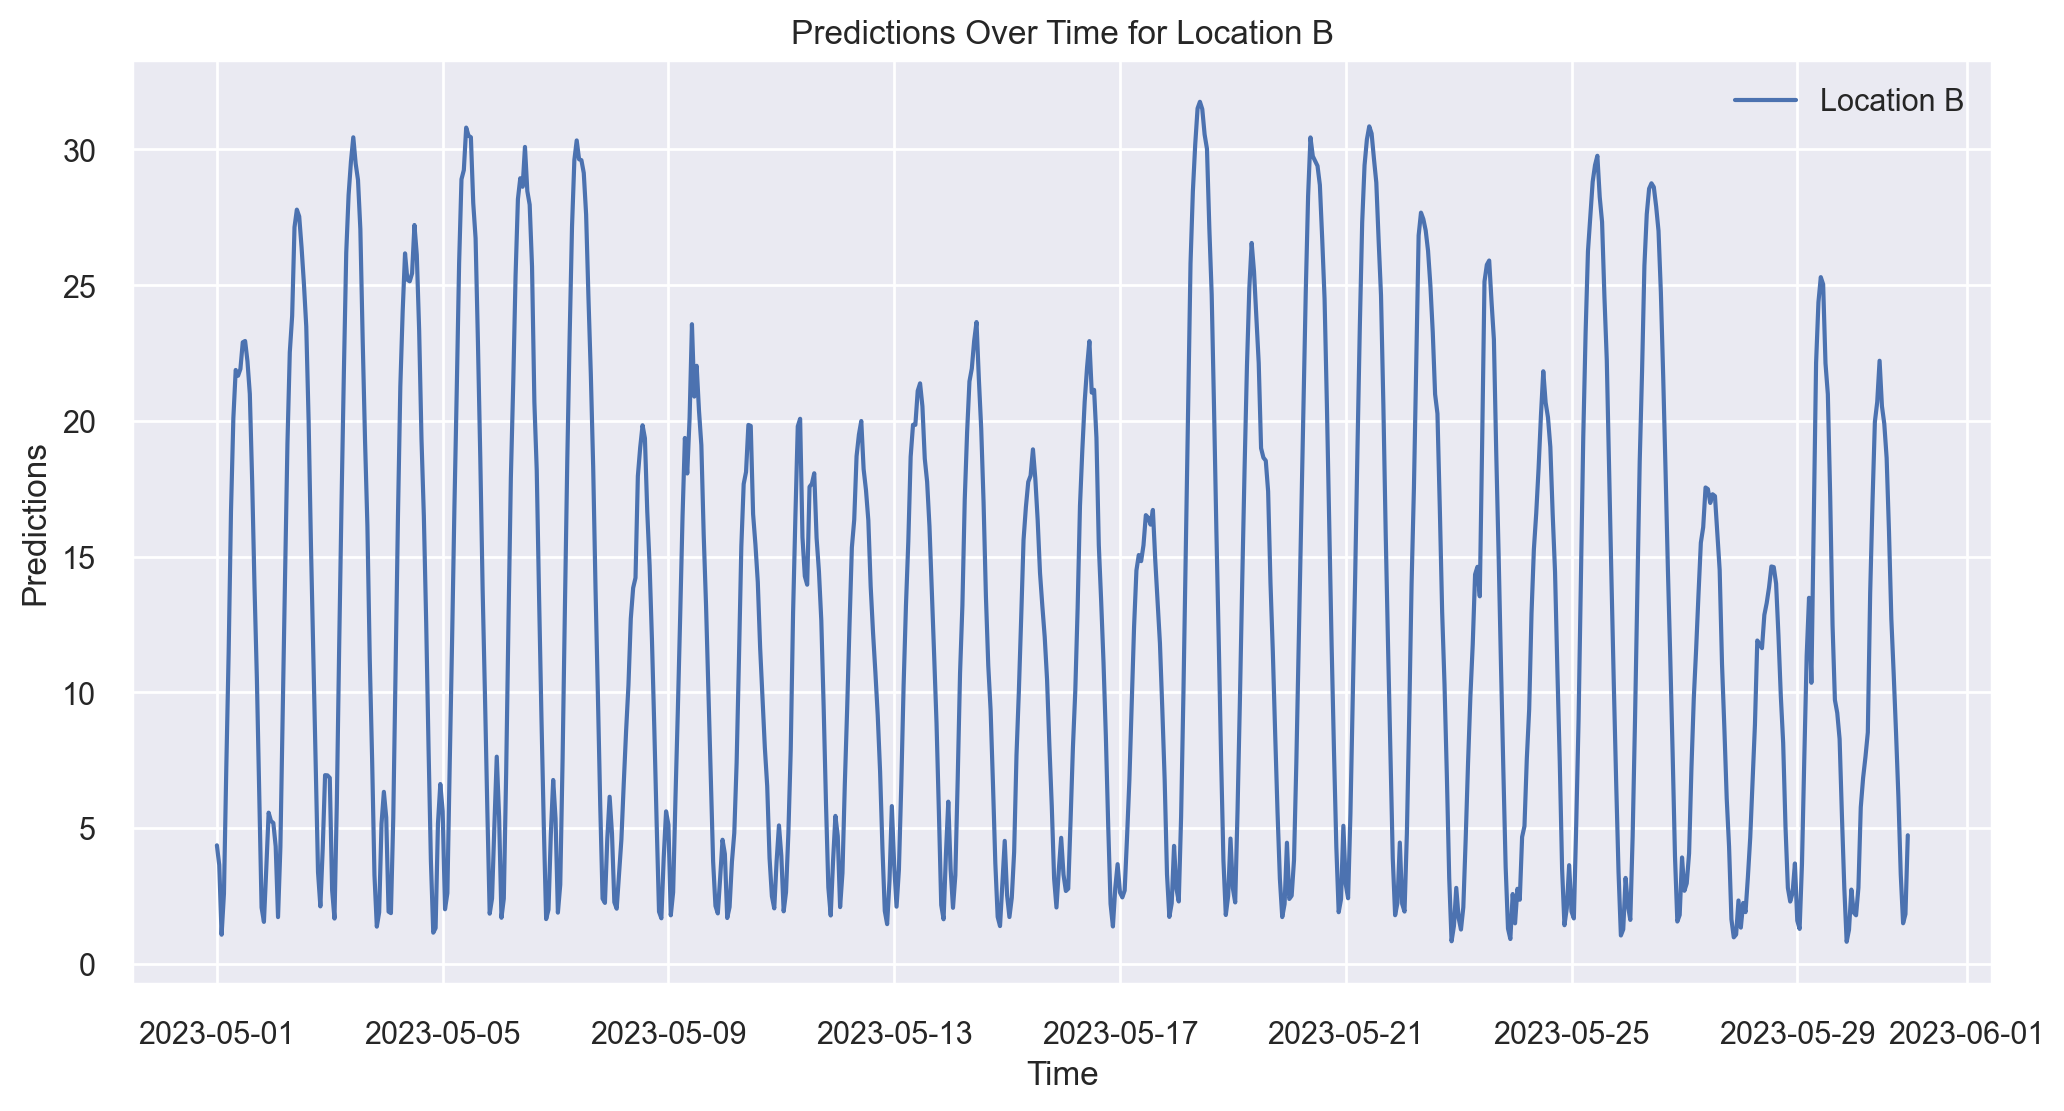

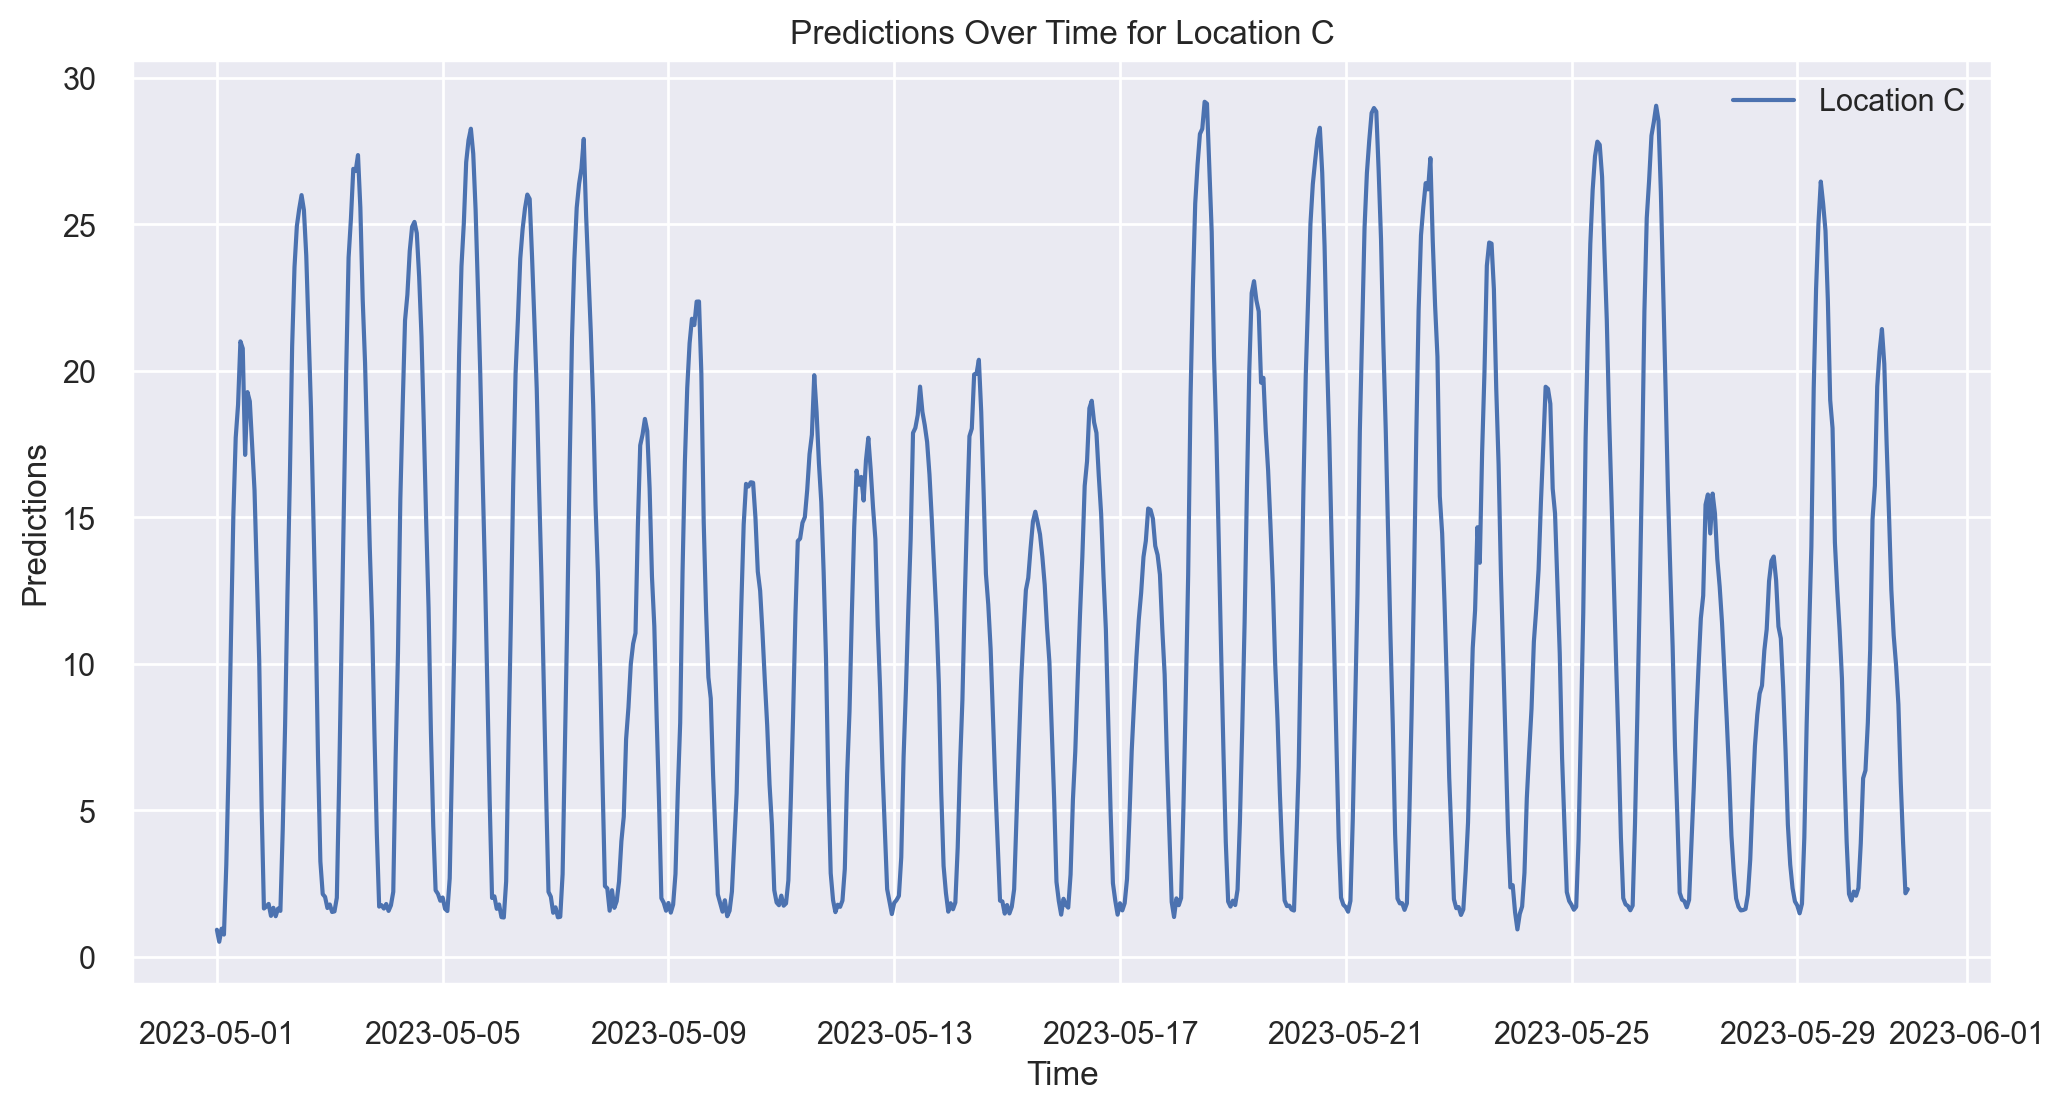

In [37]:
from pycaret.regression import *

locations = ['A','B', 'C']
all_predictions = []
final_df_list = [] 


for loc in locations:
    # Load your data
    train = pd.read_parquet(f'Data/{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'Data/{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'Data/{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'Data/{loc}/X_test_estimated.parquet')

    #lage dag og måned feature der man aggregerer opp 
    # Preprocess data
    X_train, X_test, is_day_feature, targets = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)
    y_train = targets
    if X_train.empty or len(y_train) == 0:
        print(f"X_train or y_train is empty for location {loc}")

    # Ensure X and y have the same length
    # print(len(X_train), 'X')
    # print(len(y_train),'y')
    min_length = min(len(X_train), len(y_train))
    X_train, y_train = X_train.iloc[:min_length], y_train[:min_length]


    data = X_train.copy()
    data.columns = data.columns.str.replace('[^\w\s]', '')

    X_test.columns = X_test.columns.str.replace('[^\w\s]', '')


    data['target'] = np.sqrt(y_train['pv_measurement'])
    
    cat_fe = ['dew_or_rimeidx', 'is_in_shadowidx', 'is_estimated']

    exp_reg = RegressionExperiment()
    exp_reg.setup(
        data=data, 
        target='target', 
        session_id=123,
        categorical_features=cat_fe,
        # html=False,
        experiment_name=f'exp_{loc}', 
        # use_gpu=True,
        # verbose=False,
        # fold = 2,
        n_jobs=1,
    )
    
    # Process the location data and get the final model
    model_catboost = exp_reg.create_model('catboost', random_state = 123)
    print("Catboost Done")
    print("#############################################")
    model_lightgbm = exp_reg.create_model('lightgbm', random_state = 123)
    print("LGBM Done")
    print("#############################################")
    # # model_xtra_tree = exp_reg.create_model('et', random_state = 123)
    # # print("Xtra tree Done")
    # # print("#############################################")
    
    model_catboost_feature_importance = pd.DataFrame(model_catboost.feature_importances_, index=model_catboost.feature_names_, columns = ["Importance"])
    model_catboost_feature_importance.sort_values(by="Importance", ascending=False, inplace=True)
    model_catboost_feature_not_importance_names = model_catboost_feature_importance[model_catboost_feature_importance["Importance"] < .5].index.tolist()
    print(f"Cat: {len(model_catboost_feature_not_importance_names)}")
    
    model_lightgbm_feature_importance = pd.DataFrame(model_lightgbm.feature_importances_, index=model_lightgbm.feature_name_, columns = ["Importance"])
    model_lightgbm_feature_importance.sort_values(by="Importance", ascending=False, inplace=True)
    model_lightgbm_feature_not_importance_names = model_lightgbm_feature_importance[model_lightgbm_feature_importance["Importance"] < .5].index.tolist()
    print(f"LGBM: {len(model_lightgbm_feature_not_importance_names)}")
    
    # model_xtra_tree_feature_importance = pd.DataFrame(model_xtra_tree.feature_importances_, index=model_xtra_tree.feature_names_in_, columns = ["Importance"])
    # model_xtra_tree_feature_importance.sort_values(by="Importance", ascending=False, inplace=True)
    # model_xtra_tree_feature_not_importance_names = model_xtra_tree_feature_importance[model_xtra_tree_feature_importance["Importance"] < .5].index.tolist()
    # print(f"Et: {len(model_xtra_tree_feature_not_importance_names)}"
    
    # non_significant_features = list(set(model_catboost_feature_not_importance_names) & set(model_lightgbm_feature_not_importance_names) & set(model_xtra_tree_feature_not_importance_names))
    non_significant_features = list(set(model_catboost_feature_not_importance_names) & set(model_lightgbm_feature_not_importance_names))
    print(f"{loc} Removes: {len(non_significant_features)} features\n{loc} Keep: {len(data.columns) - len(non_significant_features)} features")
    
    # if loc == 'A':
    #     non_significant_features_0_point_5_upper_limit = ['fresh_snow_12hcm', 'is_in_shadowidx_0.75', 'snow_melt_10minmm_rolling_avg_5', 'prob_rimep_rolling_avg_5', 'is_in_shadowidx_1.0', 'is_estimated', 'fresh_snow_3hcm_rolling_avg_5', 'is_in_shadowidx_0.0', 'snow_melt_10minmm_rolling_avg_3', 'prob_rimep', 'is_dayidx', 'elevationm', 'snow_depthcm_rolling_avg_7', 'dew_or_rimeidx_0.75', 'fresh_snow_6hcm_rolling_avg_5', 'fresh_snow_1hcm_rolling_avg_5', 'dew_or_rimeidx_-1.0', 'prob_rimep_rolling_avg_3', 'snow_melt_10minmm', 'is_in_shadowidx_0.25', 'snow_densitykgm3', 'fresh_snow_3hcm_rolling_avg_7', 'dew_or_rimeidx_-0.5', 'prob_rimep_rolling_avg_7', 'dew_or_rimeidx_0.0', 'dew_or_rimeidx_-0.25', 'fresh_snow_1hcm', 'dew_or_rimeidx_-0.75', 'fresh_snow_6hcm', 'dew_or_rimeidx_0.5', 'dew_or_rimeidx_0.25', 'fresh_snow_3hcm_rolling_avg_3', 'is_in_shadowidx_0.5', 'fresh_snow_6hcm_rolling_avg_3', 'snow_melt_10minmm_rolling_avg_7', 'fresh_snow_1hcm_rolling_avg_7', 'wind_speed_w_1000hPams', 'snow_driftidx', 'dew_or_rimeidx_1.0', 'fresh_snow_1hcm_rolling_avg_3', 'snow_depthcm_rolling_avg_5', 'fresh_snow_3hcm']
    # elif loc == 'B':
    #     non_significant_features_0_point_5_upper_limit = ['is_in_shadowidx_0.75', 'prob_rimep_rolling_avg_5', 'is_in_shadowidx_1.0', 'fresh_snow_24hcm', 'is_estimated', 'fresh_snow_3hcm_rolling_avg_5', 'is_in_shadowidx_0.0', 'snow_melt_10minmm_rolling_avg_3', 'fresh_snow_12hcm_rolling_avg_7', 'prob_rimep', 'is_dayidx', 'elevationm', 'fresh_snow_12hcm_rolling_avg_3', 'fresh_snow_24hcm_rolling_avg_3', 'dew_or_rimeidx_0.75', 'fresh_snow_6hcm_rolling_avg_5', 'fresh_snow_1hcm_rolling_avg_5', 'prob_rimep_rolling_avg_3', 'dew_or_rimeidx_-1.0', 'snow_melt_10minmm', 'snow_densitykgm3', 'is_in_shadowidx_0.25', 'fresh_snow_3hcm_rolling_avg_7', 'dew_or_rimeidx_-0.5', 'prob_rimep_rolling_avg_7', 'dew_or_rimeidx_0.0', 'dew_or_rimeidx_-0.25', 'fresh_snow_1hcm', 'fresh_snow_6hcm', 'dew_or_rimeidx_0.5', 'is_in_shadowidx_rolling_avg_3', 'dew_or_rimeidx_0.25', 'fresh_snow_12hcm_rolling_avg_5', 'fresh_snow_6hcm_rolling_avg_7', 'fresh_snow_3hcm_rolling_avg_3', 'is_in_shadowidx_0.5', 'fresh_snow_1hcm_rolling_avg_3', 'wind_speed_w_1000hPams', 'fresh_snow_6hcm_rolling_avg_3', 'fresh_snow_1hcm_rolling_avg_7', 'snow_driftidx', 'dew_or_rimeidx_1.0', 'fresh_snow_3hcm', 'snow_depthcm_rolling_avg_3']
    # elif loc == 'C':
    #     non_significant_features_0_point_5_upper_limit = ['is_in_shadowidx_0.75', 'snow_melt_10minmm_rolling_avg_5', 'prob_rimep_rolling_avg_5', 'is_in_shadowidx_1.0', 'fresh_snow_3hcm_rolling_avg_5', 'is_in_shadowidx_0.0', 'snow_melt_10minmm_rolling_avg_3', 'prob_rimep', 'is_dayidx', 'elevationm', 'dew_or_rimeidx_0.75', 'fresh_snow_1hcm_rolling_avg_5', 'is_in_shadowidx_0.25', 'prob_rimep_rolling_avg_3', 'dew_or_rimeidx_-1.0', 'snow_melt_10minmm', 'snow_densitykgm3', 'fresh_snow_3hcm_rolling_avg_7', 'prob_rimep_rolling_avg_7', 'dew_or_rimeidx_-0.5', 'dew_or_rimeidx_0.0', 'dew_or_rimeidx_-0.25', 'fresh_snow_1hcm', 'dew_or_rimeidx_-0.75', 'fresh_snow_6hcm', 'dew_or_rimeidx_0.5', 'dew_or_rimeidx_0.25', 'snow_depthcm', 'fresh_snow_6hcm_rolling_avg_7', 'fresh_snow_3hcm_rolling_avg_3', 'is_in_shadowidx_0.5', 'fresh_snow_1hcm_rolling_avg_3', 'snow_melt_10minmm_rolling_avg_7', 'fresh_snow_1hcm_rolling_avg_7', 'snow_driftidx', 'dew_or_rimeidx_1.0', 'snow_depthcm_rolling_avg_5', 'fresh_snow_3hcm', 'snow_depthcm_rolling_avg_3']

    # non_significant_features = non_significant_features_0_point_5_upper_limit
    
    if len(list(set(non_significant_features) & set(cat_fe))) != 0:
        for i in list(set(non_significant_features) & set(cat_fe)):
            cat_fe.remove(i)
    print(cat_fe)

    exp_reg_red = RegressionExperiment()
    exp_reg_red.setup(
        data=data, 
        target='target', 
        session_id=123,
        categorical_features = cat_fe,
        ignore_features = non_significant_features,
        # html=False,
        experiment_name=f'exp_{loc}_red', 
        use_gpu=True,
        # verbose=False,
        # fold = 2,
        n_jobs=1,
    )
    print(non_significant_features)
    
    # Process the location data and get the final model for reduced features
    model_catboost_red = exp_reg_red.create_model('catboost', random_state = 123)
    print("Catboost redused Done")
    print("#############################################")
    model_lightgbm_red = exp_reg_red.create_model('lightgbm', random_state = 123)
    print("LGBM redused Done")
    print("#############################################")
    # model_xtra_tree_red = exp_reg_red.create_model('et', random_state = 123)
    # print("Xtra tree Done")
    # print("#############################################")

    blended_models = exp_reg_red.blend_models(
        [
            model_catboost_red,
            model_lightgbm_red,
            # model_xtra_tree_red,
        ]
    )
    print("Blended")
    print("#############################################")

    # Finalize the model
    final_models = exp_reg_red.finalize_model(blended_models)
    print("Finalized")
    print("#############################################")
    
    # Predict on new data
    predictions = exp_reg_red.predict_model(final_models, data=X_test)
        #print(predictions.columns)
        # Assuming 'predictions' is the output from predict_model
    final_predictions = (predictions['prediction_label'])**2
    print(final_predictions.dtypes)
    print(is_day_feature.dtypes)
    # Multiply final predictions with the 'is_day:idx' values
    
    adjusted_final_predictions = final_predictions * is_day_feature['is_day:idx']
    adjusted_final_predictions = np.clip(adjusted_final_predictions, 0, None)
    # Now, 'adjusted_final_predictions' contains the adjusted target values.

        # Store predictions
    all_predictions.append(adjusted_final_predictions)  

        # Prepare dataframe for visualization
    num_predictions = len(predictions)
    timestamps = pd.date_range(start='2023-05-01 00:00:00', periods=num_predictions, freq='H')

    df = pd.DataFrame({
            'time': timestamps,
            'prediction': predictions['prediction_label'],
            'location': loc
        })

    final_df_list.append(df)


# Concatenate all the individual data frames and prepare for plotting
final_df = pd.concat(final_df_list, ignore_index=True)
final_df['time'] = pd.to_datetime(final_df['time'])
final_df.sort_values('time', inplace=True)

# Visualization
for loc in locations:
    # Filter data for each location
    temp_df = final_df[final_df['location'] == loc]
    
    plt.figure(figsize=(12, 6))  # Create a new figure for each location
    plt.plot(temp_df['time'], temp_df['prediction'], label=f'Location {loc}')
    plt.xlabel('Time')
    plt.ylabel('Predictions')
    plt.title(f'Predictions Over Time for Location {loc}')
    plt.legend()
    plt.show()

# If you need to save the final dataframe without 'time' and 'location' columns, you can do so before plotting
final_df_save = final_df.copy()
final_df_save = final_df_save.drop(columns=['time', 'location'])

In [ ]:
cat_lgbm_a_non_significant_0_point_5_upper_limit = ['fresh_snow_12hcm', 'is_in_shadowidx_0.75', 'snow_melt_10minmm_rolling_avg_5', 'prob_rimep_rolling_avg_5', 'is_in_shadowidx_1.0', 'is_estimated', 'fresh_snow_3hcm_rolling_avg_5', 'is_in_shadowidx_0.0', 'snow_melt_10minmm_rolling_avg_3', 'prob_rimep', 'is_dayidx', 'elevationm', 'snow_depthcm_rolling_avg_7', 'dew_or_rimeidx_0.75', 'fresh_snow_6hcm_rolling_avg_5', 'fresh_snow_1hcm_rolling_avg_5', 'dew_or_rimeidx_-1.0', 'prob_rimep_rolling_avg_3', 'snow_melt_10minmm', 'is_in_shadowidx_0.25', 'snow_densitykgm3', 'fresh_snow_3hcm_rolling_avg_7', 'dew_or_rimeidx_-0.5', 'prob_rimep_rolling_avg_7', 'dew_or_rimeidx_0.0', 'dew_or_rimeidx_-0.25', 'fresh_snow_1hcm', 'dew_or_rimeidx_-0.75', 'fresh_snow_6hcm', 'dew_or_rimeidx_0.5', 'dew_or_rimeidx_0.25', 'fresh_snow_3hcm_rolling_avg_3', 'is_in_shadowidx_0.5', 'fresh_snow_6hcm_rolling_avg_3', 'snow_melt_10minmm_rolling_avg_7', 'fresh_snow_1hcm_rolling_avg_7', 'wind_speed_w_1000hPams', 'snow_driftidx', 'dew_or_rimeidx_1.0', 'fresh_snow_1hcm_rolling_avg_3', 'snow_depthcm_rolling_avg_5', 'fresh_snow_3hcm']
cat_lgbm_b_non_significant_0_point_5_upper_limit = ['is_in_shadowidx_0.75', 'prob_rimep_rolling_avg_5', 'is_in_shadowidx_1.0', 'fresh_snow_24hcm', 'is_estimated', 'fresh_snow_3hcm_rolling_avg_5', 'is_in_shadowidx_0.0', 'snow_melt_10minmm_rolling_avg_3', 'fresh_snow_12hcm_rolling_avg_7', 'prob_rimep', 'is_dayidx', 'elevationm', 'fresh_snow_12hcm_rolling_avg_3', 'fresh_snow_24hcm_rolling_avg_3', 'dew_or_rimeidx_0.75', 'fresh_snow_6hcm_rolling_avg_5', 'fresh_snow_1hcm_rolling_avg_5', 'prob_rimep_rolling_avg_3', 'dew_or_rimeidx_-1.0', 'snow_melt_10minmm', 'snow_densitykgm3', 'is_in_shadowidx_0.25', 'fresh_snow_3hcm_rolling_avg_7', 'dew_or_rimeidx_-0.5', 'prob_rimep_rolling_avg_7', 'dew_or_rimeidx_0.0', 'dew_or_rimeidx_-0.25', 'fresh_snow_1hcm', 'fresh_snow_6hcm', 'dew_or_rimeidx_0.5', 'is_in_shadowidx_rolling_avg_3', 'dew_or_rimeidx_0.25', 'fresh_snow_12hcm_rolling_avg_5', 'fresh_snow_6hcm_rolling_avg_7', 'fresh_snow_3hcm_rolling_avg_3', 'is_in_shadowidx_0.5', 'fresh_snow_1hcm_rolling_avg_3', 'wind_speed_w_1000hPams', 'fresh_snow_6hcm_rolling_avg_3', 'fresh_snow_1hcm_rolling_avg_7', 'snow_driftidx', 'dew_or_rimeidx_1.0', 'fresh_snow_3hcm', 'snow_depthcm_rolling_avg_3']
cat_lgbm_c_non_significant_0_point_5_upper_limit = ['is_in_shadowidx_0.75', 'snow_melt_10minmm_rolling_avg_5', 'prob_rimep_rolling_avg_5', 'is_in_shadowidx_1.0', 'fresh_snow_3hcm_rolling_avg_5', 'is_in_shadowidx_0.0', 'snow_melt_10minmm_rolling_avg_3', 'prob_rimep', 'is_dayidx', 'elevationm', 'dew_or_rimeidx_0.75', 'fresh_snow_1hcm_rolling_avg_5', 'is_in_shadowidx_0.25', 'prob_rimep_rolling_avg_3', 'dew_or_rimeidx_-1.0', 'snow_melt_10minmm', 'snow_densitykgm3', 'fresh_snow_3hcm_rolling_avg_7', 'prob_rimep_rolling_avg_7', 'dew_or_rimeidx_-0.5', 'dew_or_rimeidx_0.0', 'dew_or_rimeidx_-0.25', 'fresh_snow_1hcm', 'dew_or_rimeidx_-0.75', 'fresh_snow_6hcm', 'dew_or_rimeidx_0.5', 'dew_or_rimeidx_0.25', 'snow_depthcm', 'fresh_snow_6hcm_rolling_avg_7', 'fresh_snow_3hcm_rolling_avg_3', 'is_in_shadowidx_0.5', 'fresh_snow_1hcm_rolling_avg_3', 'snow_melt_10minmm_rolling_avg_7', 'fresh_snow_1hcm_rolling_avg_7', 'snow_driftidx', 'dew_or_rimeidx_1.0', 'snow_depthcm_rolling_avg_5', 'fresh_snow_3hcm', 'snow_depthcm_rolling_avg_3']

In [ ]:
cat_lgbm_a_non_significant_0_point_5_upper_limit_sqrt = ['is_dayidx', 'snow_densitykgm3', 'dew_or_rimeidx_0.75', 'fresh_snow_6hcm', 'is_estimated', 'fresh_snow_1hcm_rolling_avg_3', 'elevationm', 'dew_or_rimeidx_-0.25', 'dew_or_rimeidx_0.5', 'dew_or_rimeidx_-0.75', 'dew_or_rimeidx_1.0', 'is_in_shadowidx_1.0', 'fresh_snow_1hcm', 'wind_speed_w_1000hPams', 'is_in_shadowidx_0.5', 'prob_rimep', 'fresh_snow_6hcm_rolling_avg_5', 'snow_melt_10minmm', 'dew_or_rimeidx_-1.0', 'dew_or_rimeidx_-0.5', 'snow_melt_10minmm_rolling_avg_3', 'fresh_snow_24hcm_rolling_avg_5', 'dew_or_rimeidx_0.0', 'snow_driftidx', 'is_in_shadowidx_0.75', 'fresh_snow_24hcm_rolling_avg_3', 'is_in_shadowidx_0.25', 'fresh_snow_3hcm_rolling_avg_3', 'prob_rimep_rolling_avg_7', 'fresh_snow_3hcm', 'prob_rimep_rolling_avg_5', 'dew_or_rimeidx_0.25', 'prob_rimep_rolling_avg_3', 'snow_melt_10minmm_rolling_avg_7', 'is_in_shadowidx_0.0', 'fresh_snow_6hcm_rolling_avg_3', 'fresh_snow_1hcm_rolling_avg_5']
cat_lgbm_b_non_significant_0_point_5_upper_limit_sqrt = ['is_dayidx', 'snow_densitykgm3', 'dew_or_rimeidx_0.75', 'fresh_snow_6hcm', 'is_estimated', 'fresh_snow_1hcm_rolling_avg_3', 'elevationm', 'fresh_snow_3hcm_rolling_avg_5', 'dew_or_rimeidx_-0.25', 'dew_or_rimeidx_0.5', 'dew_or_rimeidx_1.0', 'is_in_shadowidx_1.0', 'fresh_snow_1hcm', 'wind_speed_w_1000hPams', 'is_in_shadowidx_0.5', 'prob_rimep', 'fresh_snow_6hcm_rolling_avg_5', 'snow_melt_10minmm', 'dew_or_rimeidx_-1.0', 'snow_melt_10minmm_rolling_avg_3', 'dew_or_rimeidx_0.0', 'snow_driftidx', 'is_in_shadowidx_0.75', 'is_in_shadowidx_0.25', 'fresh_snow_1hcm_rolling_avg_7', 'fresh_snow_3hcm_rolling_avg_3', 'fresh_snow_3hcm', 'dew_or_rimeidx_0.25', 'prob_rimep_rolling_avg_3', 'dew_or_rimeidx_-0.5', 'fresh_snow_6hcm_rolling_avg_3', 'fresh_snow_1hcm_rolling_avg_5']
cat_lgbm_c_non_significant_0_point_5_upper_limit_sqrt = ['is_dayidx', 'snow_densitykgm3', 'dew_or_rimeidx_0.75', 'fresh_snow_1hcm_rolling_avg_3', 'elevationm', 'dew_or_rimeidx_-0.25', 'dew_or_rimeidx_0.5', 'dew_or_rimeidx_-0.75', 'dew_or_rimeidx_1.0', 'is_in_shadowidx_1.0', 'snow_depthcm', 'fresh_snow_1hcm', 'is_in_shadowidx_0.5', 'prob_rimep', 'snow_depthcm_rolling_avg_3', 'snow_melt_10minmm', 'dew_or_rimeidx_-1.0', 'dew_or_rimeidx_-0.5', 'fresh_snow_24hcm_rolling_avg_5', 'snow_melt_10minmm_rolling_avg_3', 'dew_or_rimeidx_0.0', 'snow_driftidx', 'is_in_shadowidx_0.75', 'is_in_shadowidx_0.25', 'fresh_snow_1hcm_rolling_avg_7', 'fresh_snow_3hcm_rolling_avg_3', 'fresh_snow_3hcm', 'prob_rimep_rolling_avg_5', 'dew_or_rimeidx_0.25', 'snow_melt_10minmm_rolling_avg_5', 'prob_rimep_rolling_avg_3', 'snow_melt_10minmm_rolling_avg_7', 'is_in_shadowidx_0.0', 'snow_depthcm_rolling_avg_5', 'fresh_snow_1hcm_rolling_avg_5']

In [63]:
cat_lgbm_a_non_significant_0_point_25_upper_limit = ['snow_densitykgm3', 'fresh_snow_1hcm_rolling_avg_7', 'fresh_snow_6hcm', 'snow_depthcm_rolling_avg_7', 'dew_or_rimeidx_0.5', 'fresh_snow_3hcm_rolling_avg_3', 'dew_or_rimeidx_-0.5', 'is_in_shadowidx_0.0', 'is_dayidx', 'dew_or_rimeidx_0.0', 'fresh_snow_3hcm_rolling_avg_7', 'fresh_snow_6hcm_rolling_avg_3', 'dew_or_rimeidx_0.25', 'elevationm', 'fresh_snow_1hcm', 'snow_melt_10minmm_rolling_avg_7', 'is_in_shadowidx_0.5', 'is_in_shadowidx_1.0', 'is_in_shadowidx_0.25', 'snow_melt_10minmm_rolling_avg_5', 'dew_or_rimeidx_1.0', 'wind_speed_w_1000hPams', 'fresh_snow_3hcm_rolling_avg_5', 'prob_rimep_rolling_avg_7', 'fresh_snow_12hcm', 'fresh_snow_1hcm_rolling_avg_5', 'dew_or_rimeidx_-1.0', 'prob_rimep_rolling_avg_3', 'snow_driftidx', 'fresh_snow_6hcm_rolling_avg_5', 'is_estimated', 'dew_or_rimeidx_0.75', 'fresh_snow_3hcm', 'snow_depthcm_rolling_avg_5', 'snow_melt_10minmm_rolling_avg_3', 'dew_or_rimeidx_-0.75', 'prob_rimep_rolling_avg_5', 'fresh_snow_1hcm_rolling_avg_3', 'snow_melt_10minmm', 'is_in_shadowidx_0.75', 'dew_or_rimeidx_-0.25', 'prob_rimep']
cat_lgbm_b_non_significant_0_point_25_upper_limit = ['snow_densitykgm3', 'fresh_snow_1hcm_rolling_avg_7', 'fresh_snow_6hcm', 'dew_or_rimeidx_0.5', 'fresh_snow_3hcm_rolling_avg_3', 'dew_or_rimeidx_-0.5', 'fresh_snow_24hcm', 'is_in_shadowidx_0.0', 'is_dayidx', 'dew_or_rimeidx_0.0', 'fresh_snow_3hcm_rolling_avg_7', 'fresh_snow_6hcm_rolling_avg_3', 'is_in_shadowidx_rolling_avg_3', 'dew_or_rimeidx_0.25', 'elevationm', 'fresh_snow_1hcm', 'is_in_shadowidx_0.5', 'is_in_shadowidx_1.0', 'is_in_shadowidx_0.25', 'fresh_snow_12hcm_rolling_avg_5', 'dew_or_rimeidx_1.0', 'wind_speed_w_1000hPams', 'fresh_snow_3hcm_rolling_avg_5', 'prob_rimep_rolling_avg_7', 'fresh_snow_12hcm_rolling_avg_7', 'fresh_snow_12hcm_rolling_avg_3', 'fresh_snow_1hcm_rolling_avg_5', 'dew_or_rimeidx_-1.0', 'prob_rimep_rolling_avg_3', 'snow_driftidx', 'fresh_snow_24hcm_rolling_avg_3', 'fresh_snow_3hcm', 'fresh_snow_6hcm_rolling_avg_5', 'dew_or_rimeidx_0.75', 'is_estimated', 'prob_rimep_rolling_avg_5', 'snow_melt_10minmm_rolling_avg_3', 'snow_depthcm_rolling_avg_3', 'fresh_snow_1hcm_rolling_avg_3', 'fresh_snow_6hcm_rolling_avg_7', 'snow_melt_10minmm', 'is_in_shadowidx_0.75', 'dew_or_rimeidx_-0.25', 'prob_rimep']
cat_lgbm_c_non_significant_0_point_25_upper_limit = ['snow_densitykgm3', 'fresh_snow_1hcm_rolling_avg_7', 'fresh_snow_6hcm', 'dew_or_rimeidx_0.5', 'fresh_snow_3hcm_rolling_avg_3', 'dew_or_rimeidx_-0.5', 'is_in_shadowidx_0.0', 'is_dayidx', 'dew_or_rimeidx_0.0', 'fresh_snow_3hcm_rolling_avg_7', 'dew_or_rimeidx_0.25', 'snow_depthcm', 'elevationm', 'snow_melt_10minmm_rolling_avg_7', 'fresh_snow_1hcm', 'is_in_shadowidx_0.5', 'is_in_shadowidx_1.0', 'is_in_shadowidx_0.25', 'snow_melt_10minmm_rolling_avg_5', 'dew_or_rimeidx_1.0', 'fresh_snow_3hcm_rolling_avg_5', 'prob_rimep_rolling_avg_7', 'fresh_snow_1hcm_rolling_avg_5', 'dew_or_rimeidx_-1.0', 'prob_rimep_rolling_avg_3', 'snow_driftidx', 'fresh_snow_3hcm', 'dew_or_rimeidx_0.75', 'snow_depthcm_rolling_avg_5', 'snow_melt_10minmm_rolling_avg_3', 'dew_or_rimeidx_-0.75', 'prob_rimep_rolling_avg_5', 'snow_depthcm_rolling_avg_3', 'fresh_snow_1hcm_rolling_avg_3', 'fresh_snow_6hcm_rolling_avg_7', 'snow_melt_10minmm', 'is_in_shadowidx_0.75', 'dew_or_rimeidx_-0.25', 'prob_rimep']

In [ ]:
cat_lgbm_a_features_from_iloc_100_removed = ['pressure_50mhPa_rolling_avg_5', 'fresh_snow_3hcm_rolling_avg_5', 'fresh_snow_3hcm_rolling_avg_3', 'snow_waterkgm2', 'fresh_snow_24hcm', 'dew_or_rimeidx_-0.5', 'prob_rimep_rolling_avg_7', 'fresh_snow_1hcm_rolling_avg_3', 'sfc_pressurehPa_rolling_avg_5', 'snow_melt_10minmm_rolling_avg_5', 'is_in_shadowidx_0.25', 'dew_or_rimeidx_0.5', 'is_estimated', 'rain_waterkgm2', 'time_delta', 'msl_pressurehPa_rolling_avg_5', 'msl_pressurehPa_rolling_avg_3', 'snow_melt_10minmm', 'fresh_snow_1hcm', 'prob_rimep_rolling_avg_3', 'fresh_snow_1hcm_rolling_avg_7', 'is_in_shadowidx_1.0', 'fresh_snow_6hcm_rolling_avg_3', 'fresh_snow_1hcm_rolling_avg_5', 'snow_depthcm_rolling_avg_7', 'prob_rimep_rolling_avg_5', 'fresh_snow_12hcm_rolling_avg_5', 'wind_speed_w_1000hPams', 'fresh_snow_6hcm_rolling_avg_5', 'snow_driftidx', 'snow_melt_10minmm_rolling_avg_7', 'elevationm', 'pressure_100mhPa_rolling_avg_3', 'fresh_snow_24hcm_rolling_avg_5', 'dew_or_rimeidx_1.0', 'fresh_snow_3hcm', 'is_in_shadowidx_rolling_avg_3', 'dew_or_rimeidx_-1.0', 'dew_or_rimeidx_-0.75', 'is_dayidx', 'dew_or_rimeidx_0.25', 'fresh_snow_12hcm', 'dew_or_rimeidx_0.0', 'sfc_pressurehPa_rolling_avg_3', 'fresh_snow_6hcm', 'snow_densitykgm3', 'dew_or_rimeidx_0.75', 'prob_rimep', 'dew_or_rimeidx_-0.25', 'is_in_shadowidx_0.5', 'is_in_shadowidx_0.75', 'fresh_snow_6hcm_rolling_avg_7', 'snow_depthcm', 'fresh_snow_24hcm_rolling_avg_3', 'fresh_snow_12hcm_rolling_avg_7', 'snow_depthcm_rolling_avg_3', 'is_in_shadowidx_0.0', 'fresh_snow_3hcm_rolling_avg_7', 'fresh_snow_12hcm_rolling_avg_3', 'super_cooled_liquid_waterkgm2', 'snow_melt_10minmm_rolling_avg_3', 'pressure_50mhPa_rolling_avg_3', 'snow_depthcm_rolling_avg_5']
cat_lgbm_b_features_from_iloc_100_removed = ['fresh_snow_3hcm_rolling_avg_5', 'fresh_snow_3hcm_rolling_avg_3', 'snow_waterkgm2', 'fresh_snow_24hcm', 'precip_5minmm_rolling_avg_7', 'dew_or_rimeidx_-0.5', 'prob_rimep_rolling_avg_7', 'fresh_snow_1hcm_rolling_avg_3', 'sfc_pressurehPa_rolling_avg_5', 'snow_melt_10minmm_rolling_avg_5', 'is_in_shadowidx_0.25', 'dew_or_rimeidx_0.5', 'dew_point_2mK', 'is_estimated', 'time_delta', 'month', 'snow_melt_10minmm', 'prob_rimep_rolling_avg_3', 'fresh_snow_1hcm', 'fresh_snow_1hcm_rolling_avg_7', 'is_in_shadowidx_1.0', 'fresh_snow_6hcm_rolling_avg_3', 'fresh_snow_1hcm_rolling_avg_5', 'snow_depthcm_rolling_avg_7', 'prob_rimep_rolling_avg_5', 'fresh_snow_12hcm_rolling_avg_5', 'wind_speed_w_1000hPams', 'fresh_snow_6hcm_rolling_avg_5', 'snow_driftidx', 'snow_melt_10minmm_rolling_avg_7', 'elevationm', 'is_in_shadowidx_rolling_avg_5', 'fresh_snow_24hcm_rolling_avg_5', 'dew_or_rimeidx_1.0', 'fresh_snow_3hcm', 'dew_point_2mK_rolling_avg_3', 'dew_or_rimeidx_-1.0', 'is_in_shadowidx_rolling_avg_3', 'is_dayidx', 'dew_or_rimeidx_0.25', 'pressure_50mhPa_rolling_avg_3', 'fresh_snow_12hcm', 'fresh_snow_6hcm', 'dew_or_rimeidx_0.0', 'snow_densitykgm3', 'dew_or_rimeidx_0.75', 'prob_rimep', 'dew_or_rimeidx_-0.25', 'is_in_shadowidx_0.75', 'is_in_shadowidx_0.5', 'fresh_snow_12hcm_rolling_avg_7', 'cos_hour', 'snow_depthcm', 'fresh_snow_6hcm_rolling_avg_7', 'snow_depthcm_rolling_avg_3', 'fresh_snow_24hcm_rolling_avg_3', 'pressure_100mhPa_rolling_avg_5', 'fresh_snow_3hcm_rolling_avg_7', 'fresh_snow_12hcm_rolling_avg_3', 'is_in_shadowidx_0.0', 'absolute_humidity_2mgm3_rolling_avg_3', 'snow_melt_10minmm_rolling_avg_3', 'pressure_50mhPa_rolling_avg_5', 'snow_depthcm_rolling_avg_5']
cat_lgbm_c_features_from_iloc_100_removed = ['fresh_snow_3hcm_rolling_avg_5', 'fresh_snow_3hcm_rolling_avg_3', 'snow_waterkgm2', 'fresh_snow_24hcm', 'dew_or_rimeidx_-0.5', 'prob_rimep_rolling_avg_7', 'fresh_snow_1hcm_rolling_avg_3', 'precip_type_5minidx', 'sfc_pressurehPa_rolling_avg_5', 'is_in_shadowidx_0.25', 'snow_melt_10minmm_rolling_avg_5', 'dew_or_rimeidx_0.5', 'rain_waterkgm2', 'msl_pressurehPa_rolling_avg_3', 'fresh_snow_24hcm_rolling_avg_7', 'snow_melt_10minmm', 'prob_rimep_rolling_avg_3', 'fresh_snow_1hcm', 'fresh_snow_1hcm_rolling_avg_7', 'is_in_shadowidx_1.0', 'fresh_snow_6hcm_rolling_avg_3', 'fresh_snow_1hcm_rolling_avg_5', 'prob_rimep_rolling_avg_5', 'fresh_snow_12hcm_rolling_avg_5', 'wind_speed_w_1000hPams', 'fresh_snow_6hcm_rolling_avg_5', 'snow_driftidx', 'total_cloud_coverp_rolling_avg_3', 'snow_melt_10minmm_rolling_avg_7', 'elevationm', 'pressure_100mhPa_rolling_avg_3', 'fresh_snow_24hcm_rolling_avg_5', 'sfc_pressurehPa_rolling_avg_7', 'is_in_shadowidx_rolling_avg_5', 'pressure_50mhPa_rolling_avg_7', 'fresh_snow_3hcm', 'dew_point_2mK_rolling_avg_3', 'is_in_shadowidx_rolling_avg_3', 'dew_or_rimeidx_-1.0', 'dew_or_rimeidx_1.0', 'dew_or_rimeidx_-0.75', 'is_dayidx', 'dew_or_rimeidx_0.25', 'pressure_50mhPa_rolling_avg_3', 'fresh_snow_12hcm', 'dew_or_rimeidx_0.0', 'sfc_pressurehPa_rolling_avg_3', 'fresh_snow_6hcm', 'snow_densitykgm3', 'dew_or_rimeidx_0.75', 'prob_rimep', 'dew_or_rimeidx_-0.25', 'is_in_shadowidx_0.5', 'is_in_shadowidx_0.75', 'fresh_snow_12hcm_rolling_avg_7', 'cos_hour', 'fresh_snow_24hcm_rolling_avg_3', 'snow_depthcm', 'pressure_50mhPa', 'snow_depthcm_rolling_avg_3', 'is_in_shadowidx_0.0', 'fresh_snow_3hcm_rolling_avg_7', 'fresh_snow_12hcm_rolling_avg_3', 'fresh_snow_6hcm_rolling_avg_7', 'snow_melt_10minmm_rolling_avg_3', 'pressure_50mhPa_rolling_avg_5', 'snow_depthcm_rolling_avg_5']

In [ ]:
cat_lgbm_a_features_from_iloc_110_removed = ['is_in_shadowidx_0.5', 'dew_or_rimeidx_0.25', 'snow_densitykgm3', 'is_in_shadowidx_0.0', 'snow_melt_10minmm', 'is_in_shadowidx_1.0', 'snow_melt_10minmm_rolling_avg_7', 'is_in_shadowidx_rolling_avg_3', 'fresh_snow_12hcm_rolling_avg_5', 'dew_or_rimeidx_1.0', 'snow_driftidx', 'fresh_snow_24hcm_rolling_avg_5', 'dew_or_rimeidx_-1.0', 'fresh_snow_6hcm_rolling_avg_5', 'fresh_snow_6hcm', 'fresh_snow_1hcm', 'fresh_snow_24hcm', 'is_in_shadowidx_0.75', 'prob_rimep_rolling_avg_7', 'fresh_snow_24hcm_rolling_avg_3', 'fresh_snow_3hcm_rolling_avg_3', 'prob_rimep_rolling_avg_5', 'fresh_snow_6hcm_rolling_avg_7', 'pressure_50mhPa_rolling_avg_5', 'is_dayidx', 'fresh_snow_3hcm_rolling_avg_5', 'snow_depthcm_rolling_avg_3', 'snow_depthcm_rolling_avg_5', 'fresh_snow_3hcm', 'dew_or_rimeidx_0.75', 'fresh_snow_12hcm_rolling_avg_3', 'rain_waterkgm2', 'snow_waterkgm2', 'dew_or_rimeidx_-0.25', 'elevationm', 'fresh_snow_1hcm_rolling_avg_5', 'wind_speed_w_1000hPams', 'fresh_snow_1hcm_rolling_avg_7', 'fresh_snow_1hcm_rolling_avg_3', 'fresh_snow_12hcm_rolling_avg_7', 'dew_or_rimeidx_0.5', 'fresh_snow_3hcm_rolling_avg_7', 'prob_rimep', 'fresh_snow_6hcm_rolling_avg_3', 'prob_rimep_rolling_avg_3', 'dew_or_rimeidx_0.0', 'dew_or_rimeidx_-0.5', 'fresh_snow_12hcm', 'pressure_50mhPa_rolling_avg_3', 'dew_or_rimeidx_-0.75', 'snow_depthcm_rolling_avg_7', 'snow_depthcm', 'is_in_shadowidx_0.25', 'is_estimated', 'snow_melt_10minmm_rolling_avg_3', 'snow_melt_10minmm_rolling_avg_5']
cat_lgbm_b_features_from_iloc_110_removed = ['is_in_shadowidx_0.5', 'dew_or_rimeidx_0.25', 'snow_densitykgm3', 'is_in_shadowidx_0.0', 'snow_melt_10minmm', 'is_in_shadowidx_1.0', 'is_in_shadowidx_rolling_avg_3', 'snow_melt_10minmm_rolling_avg_7', 'fresh_snow_12hcm_rolling_avg_5', 'dew_or_rimeidx_1.0', 'is_in_shadowidx_rolling_avg_5', 'fresh_snow_6hcm', 'fresh_snow_24hcm_rolling_avg_5', 'dew_or_rimeidx_-1.0', 'fresh_snow_6hcm_rolling_avg_5', 'time_delta', 'snow_driftidx', 'fresh_snow_1hcm', 'fresh_snow_24hcm', 'is_in_shadowidx_0.75', 'prob_rimep_rolling_avg_7', 'fresh_snow_24hcm_rolling_avg_3', 'prob_rimep_rolling_avg_5', 'fresh_snow_3hcm_rolling_avg_3', 'pressure_50mhPa_rolling_avg_5', 'fresh_snow_6hcm_rolling_avg_7', 'is_dayidx', 'cos_hour', 'fresh_snow_3hcm_rolling_avg_5', 'snow_depthcm_rolling_avg_5', 'fresh_snow_3hcm', 'snow_depthcm_rolling_avg_3', 'dew_or_rimeidx_0.75', 'fresh_snow_12hcm_rolling_avg_3', 'dew_or_rimeidx_-0.25', 'elevationm', 'fresh_snow_1hcm_rolling_avg_5', 'fresh_snow_1hcm_rolling_avg_3', 'wind_speed_w_1000hPams', 'fresh_snow_1hcm_rolling_avg_7', 'fresh_snow_12hcm_rolling_avg_7', 'dew_or_rimeidx_0.5', 'fresh_snow_3hcm_rolling_avg_7', 'prob_rimep', 'precip_5minmm_rolling_avg_7', 'fresh_snow_6hcm_rolling_avg_3', 'prob_rimep_rolling_avg_3', 'dew_or_rimeidx_0.0', 'dew_or_rimeidx_-0.5', 'fresh_snow_12hcm', 'pressure_50mhPa_rolling_avg_3', 'month', 'snow_depthcm_rolling_avg_7', 'snow_depthcm', 'is_in_shadowidx_0.25', 'is_estimated', 'snow_melt_10minmm_rolling_avg_3', 'snow_melt_10minmm_rolling_avg_5']
cat_lgbm_c_features_from_iloc_110_removed = ['is_in_shadowidx_0.5', 'dew_or_rimeidx_0.25', 'snow_densitykgm3', 'is_in_shadowidx_0.0', 'snow_melt_10minmm', 'is_in_shadowidx_1.0', 'snow_melt_10minmm_rolling_avg_7', 'is_in_shadowidx_rolling_avg_3', 'dew_or_rimeidx_1.0', 'is_in_shadowidx_rolling_avg_5', 'pressure_50mhPa_rolling_avg_7', 'fresh_snow_24hcm_rolling_avg_5', 'fresh_snow_6hcm_rolling_avg_5', 'fresh_snow_6hcm', 'dew_or_rimeidx_-1.0', 'snow_driftidx', 'fresh_snow_1hcm', 'is_in_shadowidx_0.75', 'prob_rimep_rolling_avg_7', 'fresh_snow_24hcm_rolling_avg_7', 'msl_pressurehPa_rolling_avg_3', 'fresh_snow_3hcm_rolling_avg_3', 'prob_rimep_rolling_avg_5', 'pressure_50mhPa_rolling_avg_5', 'is_dayidx', 'fresh_snow_6hcm_rolling_avg_7', 'cos_hour', 'fresh_snow_3hcm_rolling_avg_5', 'snow_depthcm_rolling_avg_3', 'fresh_snow_3hcm', 'snow_depthcm_rolling_avg_5', 'dew_or_rimeidx_0.75', 'fresh_snow_12hcm_rolling_avg_3', 'rain_waterkgm2', 'dew_or_rimeidx_-0.25', 'elevationm', 'fresh_snow_1hcm_rolling_avg_5', 'wind_speed_w_1000hPams', 'fresh_snow_1hcm_rolling_avg_3', 'fresh_snow_1hcm_rolling_avg_7', 'fresh_snow_12hcm_rolling_avg_7', 'sfc_pressurehPa_rolling_avg_5', 'dew_or_rimeidx_0.5', 'fresh_snow_3hcm_rolling_avg_7', 'prob_rimep', 'fresh_snow_6hcm_rolling_avg_3', 'prob_rimep_rolling_avg_3', 'dew_or_rimeidx_0.0', 'dew_or_rimeidx_-0.5', 'fresh_snow_12hcm', 'pressure_50mhPa_rolling_avg_3', 'dew_or_rimeidx_-0.75', 'pressure_100mhPa_rolling_avg_3', 'snow_depthcm', 'is_in_shadowidx_0.25', 'snow_melt_10minmm_rolling_avg_3', 'sfc_pressurehPa_rolling_avg_7', 'snow_melt_10minmm_rolling_avg_5']

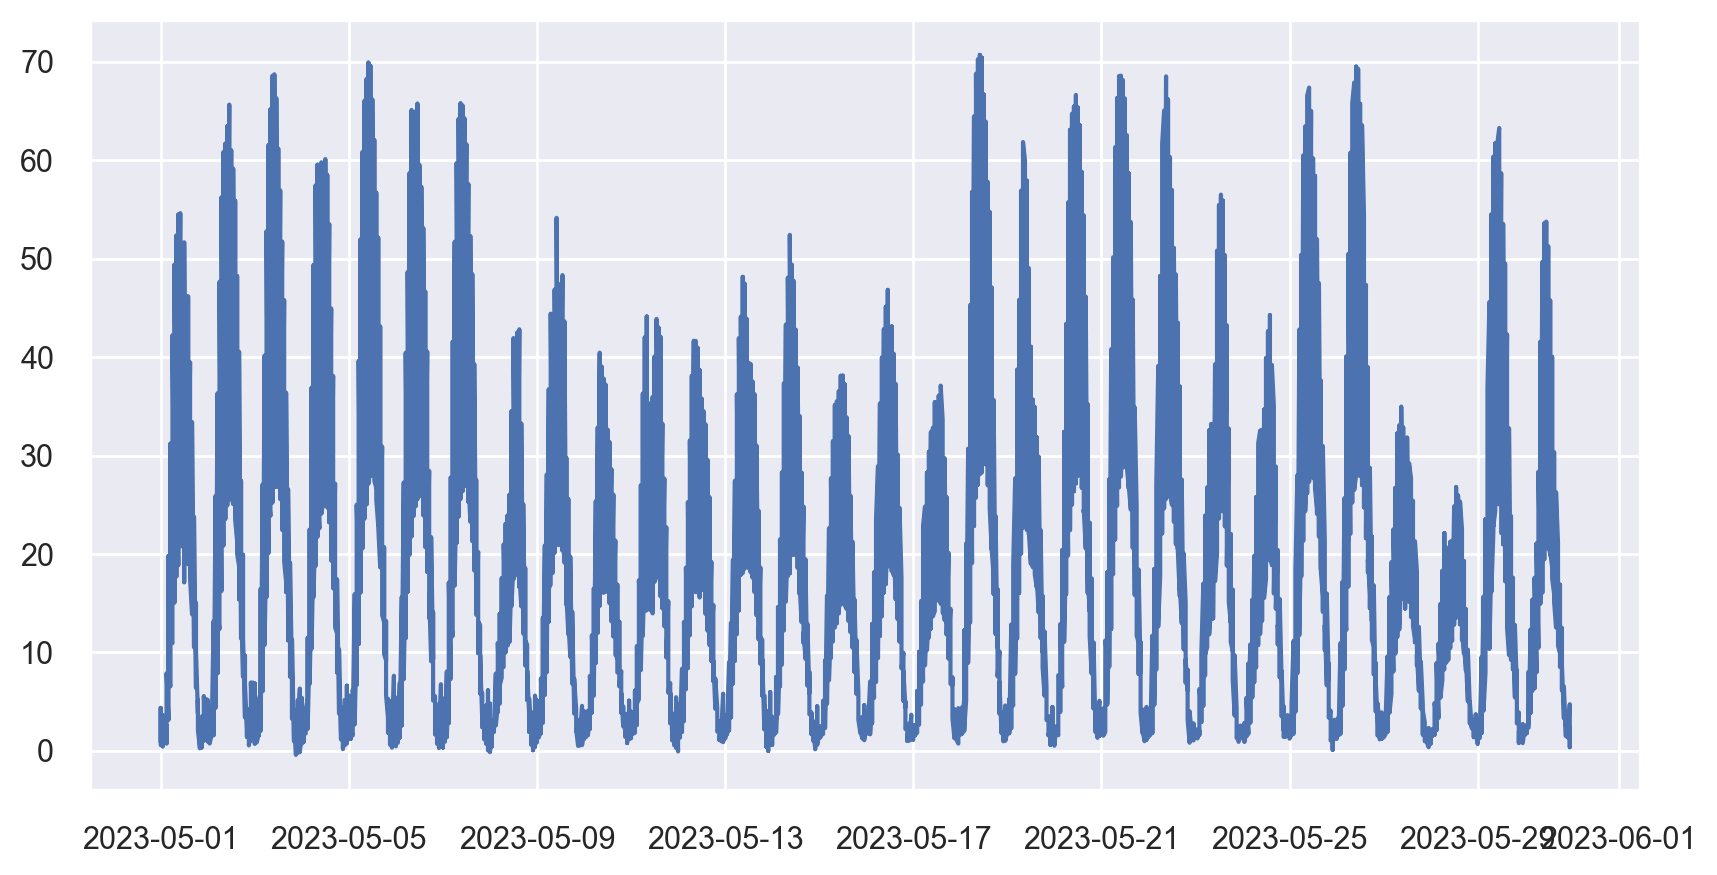

In [38]:
plt.plot(final_df['time'], final_df['prediction'], label='Prediction')

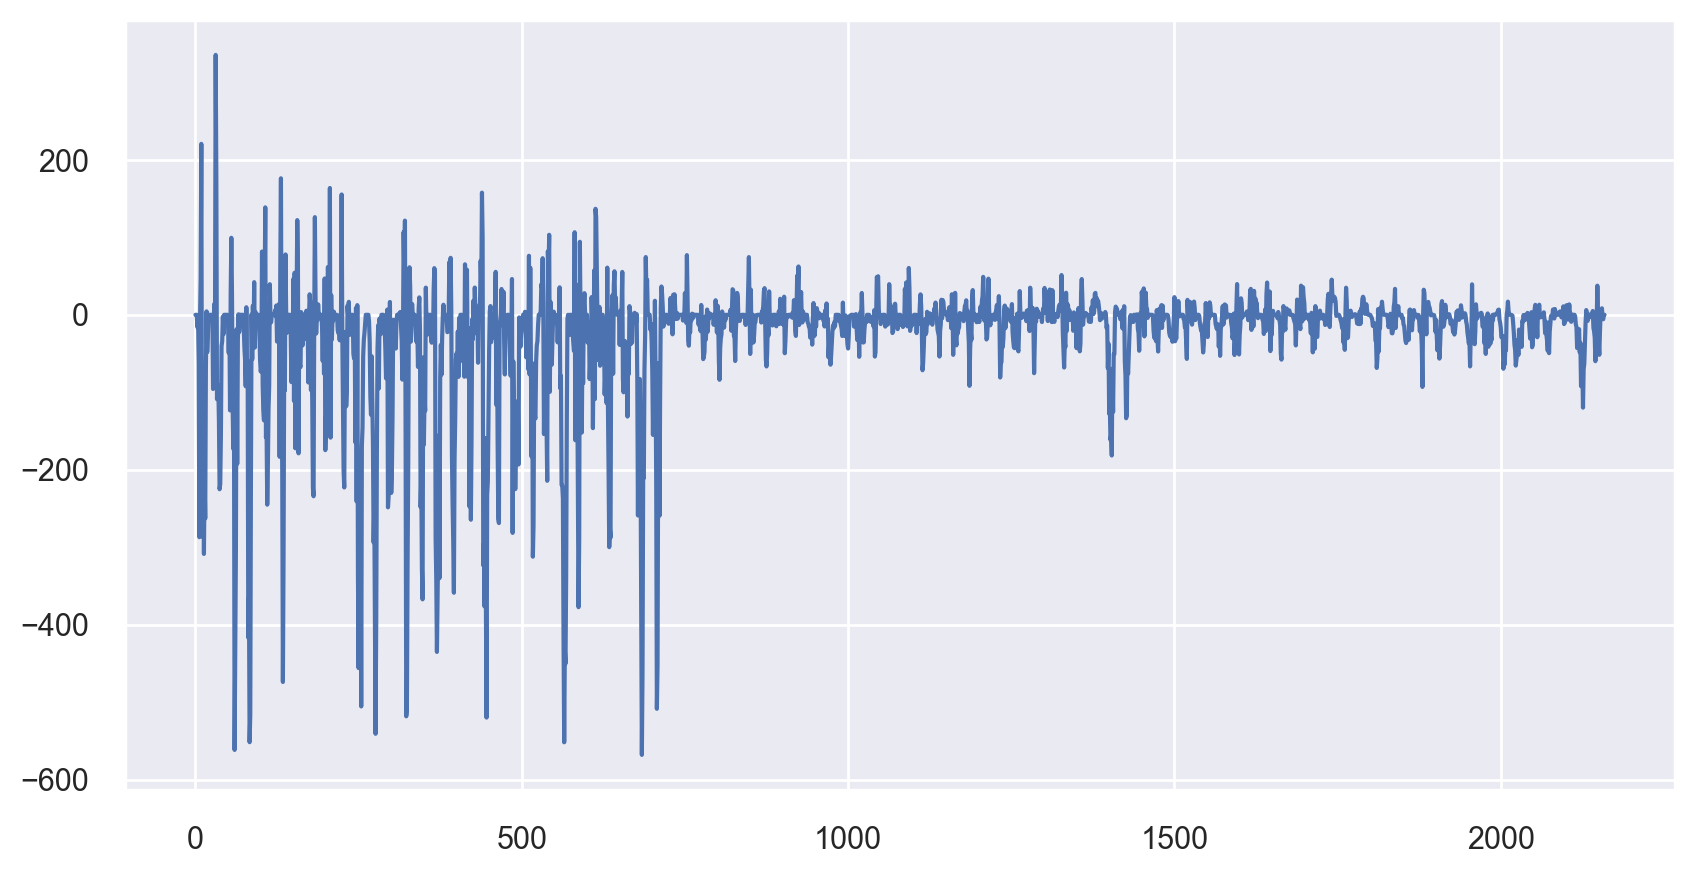

In [39]:
plt.plot(np.concatenate(all_predictions) - pd.read_csv("Predictions/multimodel_basic_cat_lgbm_0_point_5_feature_upper_limit_blended.csv")["prediction"])

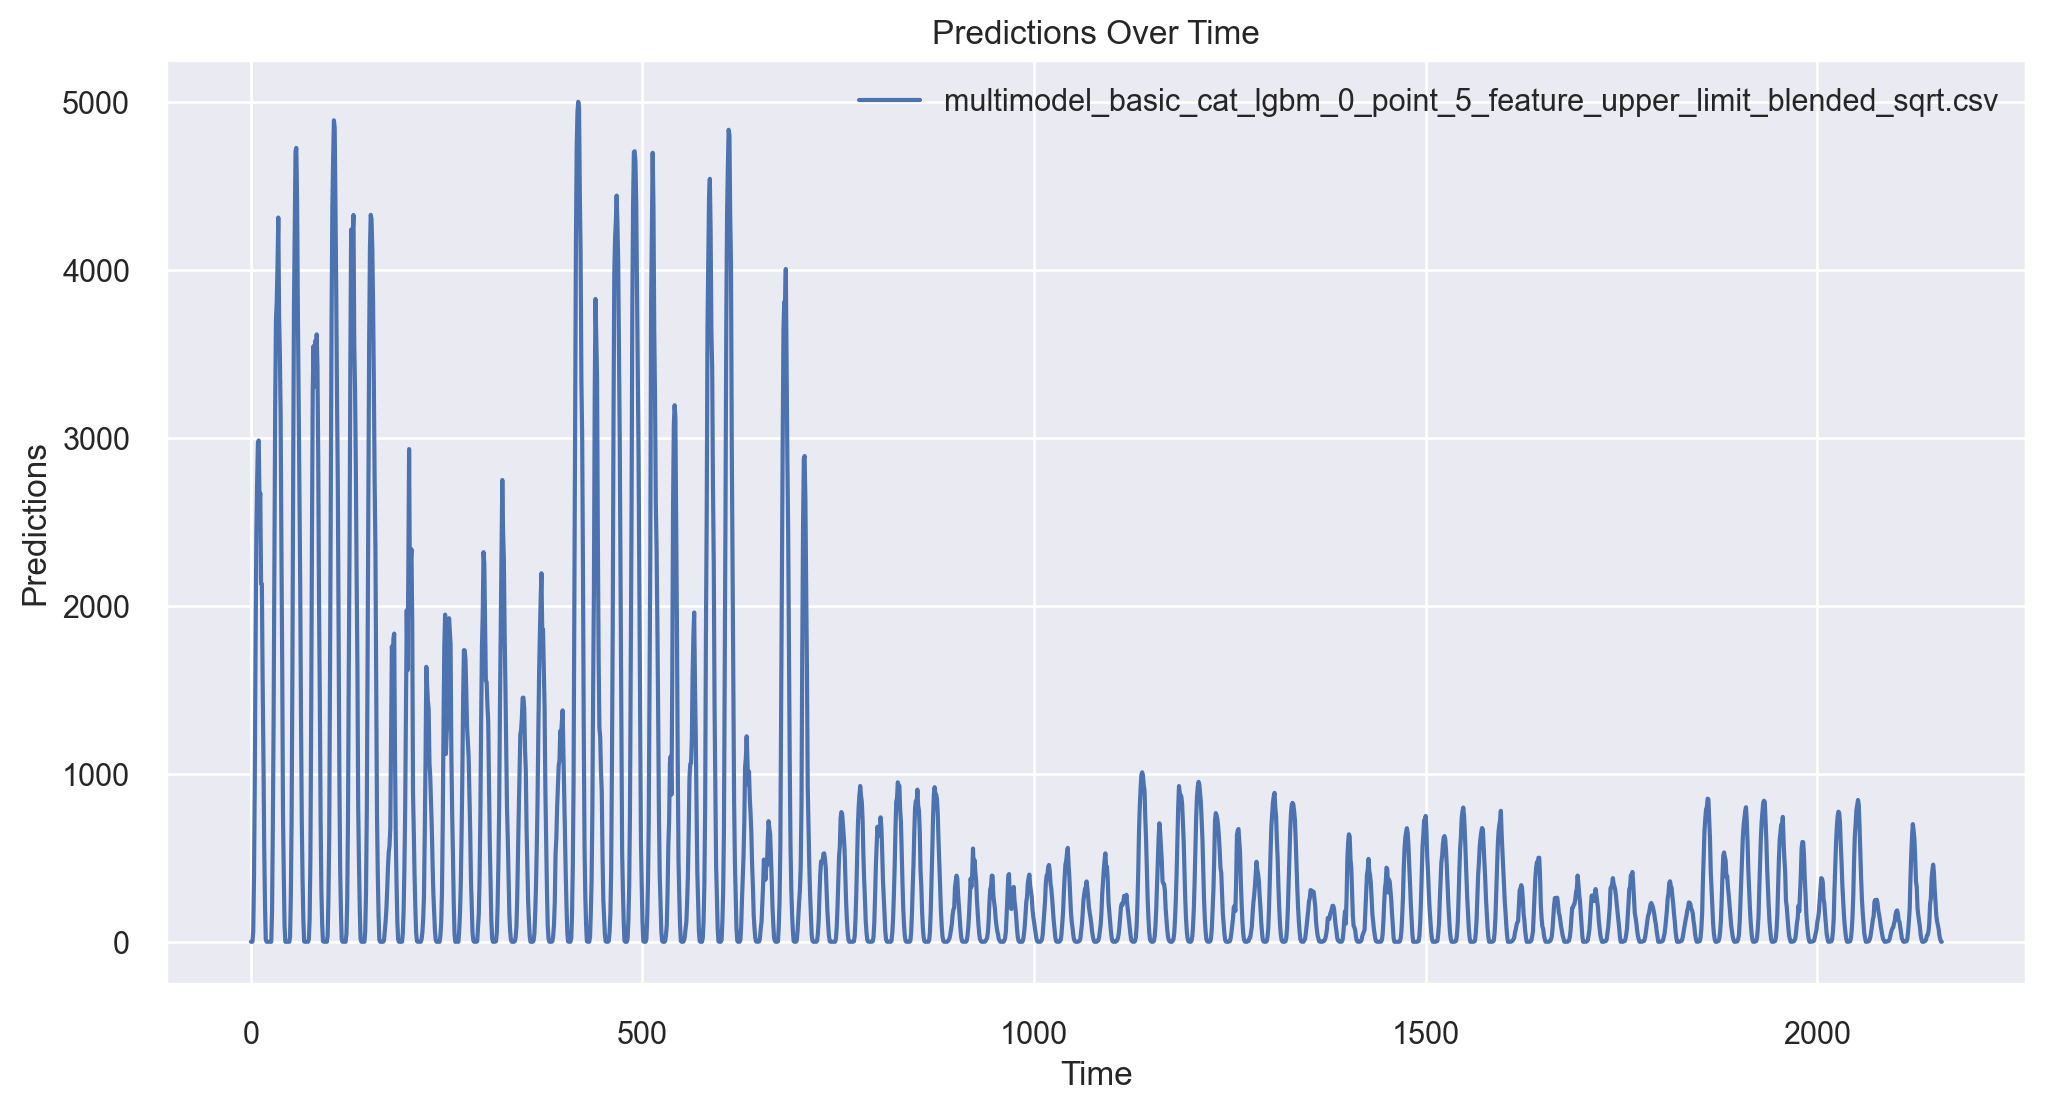

In [40]:
def save_predictions(all_predictions, title):
    final_predictions = np.concatenate(all_predictions)
    df = pd.DataFrame(final_predictions, columns=['prediction'])
    df['id'] = df.index
    df = df[['id', 'prediction']]
    df.to_csv(f"Predictions/{title}", index=False)

def plot_from_csv(title):
    plt.figure(figsize=(12, 6))
    df = pd.read_csv(f"Predictions/{title}")
    plt.plot(df['prediction'], label=title)
    plt.xlabel('Time')
    plt.ylabel('Predictions')
    plt.title('Predictions Over Time')
    plt.legend()
    plt.show()
    

title = 'multimodel_basic_cat_lgbm_0_point_5_feature_upper_limit_blended_sqrt.csv'
save_predictions(all_predictions, title)
plot_from_csv(title)


In [50]:
(np.concatenate(all_predictions) - pd.read_csv("Predictions/multimodel_basic_cat_lgbm_0_point_5_feature_upper_limit_blended.csv")["prediction"]).sum()

-5.3300419633472984e-12

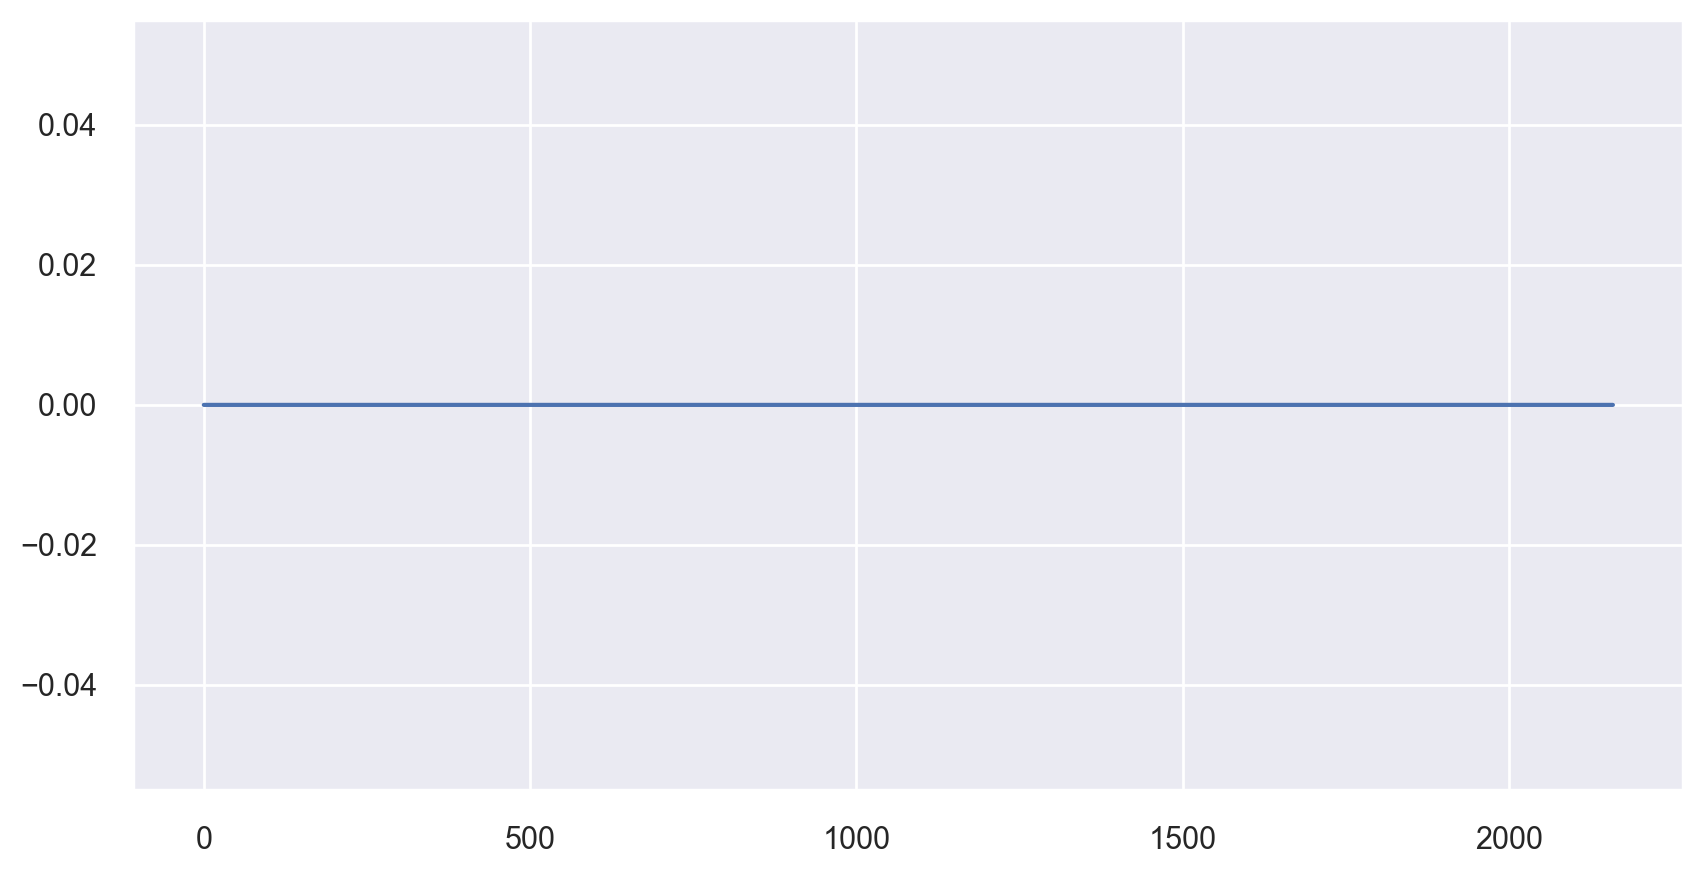

In [39]:
plt.plot(pd.read_csv("Predictions/multimodel_basic_cat_lgbm_0_point_25_feature_upper_limit_blended.csv")["prediction"] - pd.read_csv("Predictions/multimodel_basic_cat_lgbm_0_point_5_feature_upper_limit_blended.csv")["prediction"])

In [ ]:
df1 = pd.read_csv('multimodel_basic_cat_lgbm_reproduced_jman.csv')
df3 = pd.read_csv('multimodel_basic_cat_lgbm_reproduced_2.csv')

df1['prediction'] = df1['prediction'].astype(float)
df3['prediction'] = df3['prediction'].astype(float)

# Plot different between df1 and df3 
plt.figure(figsize=(24, 12))
plt.plot(df1['prediction'] - df3['prediction'], label='df1 - df3', c = 'blue')
#plt.plot(df2['prediction'] - df3['prediction'], label='df2 - df3', c = 'red')   
#plt.plot(df1['prediction'] - df2['prediction'], label='df1 - df2', c = 'green')
plt.show()

In [ ]:
import pandas as pd

val_a = 3.6317187499999997
val_b = 24.31785735278335
val_c = 5.777916666666667

# Initialize a dictionary to hold the masks
masks = {}
locations = ['A', 'B', 'C']
values = {'A': val_a, 'B': val_b, 'C': val_c}  # Dictionary to hold different values for each location

for loc in locations:
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    X_train, X_test, is_day_feature, targets = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)
    
    # Create mask for the current location where 'is_day:idx' == 0
    masks[loc] = (X_test['is_day:idx'] == 0) or (X_test['is_day:idx'] == 0.25) or (X_test['is_day:idx'] == 0.5) or (X_test['is_day:idx'] == 0.75)

    # Add a new column with the location-specific value
    masks[loc] = masks[loc].reset_index(drop=True)
    masks[loc] = pd.concat([masks[loc], pd.Series([values[loc]] * len(masks[loc]), name='Value')], axis=1)

    # Calculate mean value for the current location under is_day:idx == 1
    print(np.mean(targets[X_train['is_day:idx'] == 0]['pv_measurement']))

# Now we concatenate the masks along with their new 'Value' column
mask0 = pd.concat([masks['A'], masks['B'], masks['C']], ignore_index=True)

print(mask0)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np  # Make sure to import NumPy

# Load your data
df1 = pd.read_csv('multimodel_basic_cat_lgbm_reproduced_jman.csv')

# Ensure that mask0 is a DataFrame and has a 'Value' column with the values you want to use for replacement
# The np.where function is used to replace values where the condition is true
df1['prediction'] = np.where(mask0['is_day:idx'], mask0['Value'], df1['prediction'])

plt.figure(figsize=(24, 12))
plt.plot(df1['prediction'], label='df1')

plt.legend()
plt.show()


In [ ]:
df1.to_csv('multimodel_basic_cat_lgbm_reproduced_is_day_calc.csv', index=False)

In [ ]:
df1 = pd.read_csv('multimodel_basic_cat_lgbm_reproduced_jman.csv')
df1

In [ ]:
import pandas as pd

# Assuming 'data' is a DataFrame and 'value' is the column with your numbers.
# Replace 0 with NaN for interpolation
data = df1.copy()

# count 0's 
print(data['prediction'].value_counts()[0])
print(data['prediction'].value_counts()[0] / len(data))
